## 1.0 建立路径并读入数据

### 1.1 读入数据源并合并

In [1]:
import pathlib

path = pathlib.Path().resolve()
path

PosixPath('/Users/tuna/Desktop/p/2')

In [2]:
import pandas as pd

Hours = pd.read_csv( path / 'HoursP_fix_valid_DailySum.csv')[['date','station','crain']]
Daily = pd.read_csv( path / 'DailyP.csv')[['date','station','Prcp']]

In [3]:
print("Hours:",Hours)
print("Daily:",Daily)

Hours:               date  station  crain
0       2008-01-02    55279    0.0
1       2008-01-03    55279    0.0
2       2008-01-04    55279    0.0
3       2008-01-05    55279    0.0
4       2008-01-06    55279    0.3
...            ...      ...    ...
567397  2020-01-02    57105    0.0
567398  2020-01-03    57105    0.0
567399  2020-01-04    57105    0.0
567400  2020-01-05    57105    0.0
567401  2020-01-06    57105    0.0

[567402 rows x 3 columns]
Daily:               date  station  Prcp
0       2008-01-01    55279   0.0
1       2008-01-02    55279   0.0
2       2008-01-03    55279   0.0
3       2008-01-04    55279   0.0
4       2008-01-05    55279   0.1
...            ...      ...   ...
608975  2019-12-27    57105   0.0
608976  2019-12-28    57105   0.0
608977  2019-12-29    57105   0.0
608978  2019-12-30    57105   0.0
608979  2019-12-31    57105   0.3

[608980 rows x 3 columns]


In [4]:
# 将 station 列转换为字符串，保留整数部分
Hours['station'] = Hours['station'].astype(str).str.split('.').str[0]

# 将 DailyP 中的 station 列转换为字符串，保留整数部分
Daily['station'] = Daily['station'].astype(str).str.split('.').str[0]

# 将 date 列转换为日期格式
Hours['date'] = pd.to_datetime(Hours['date'])
Daily['date'] = pd.to_datetime(Daily['date'])

# 将 DailyP 中的 Prcp 值匹配到 HoursP_1000 中
merged_data = pd.merge(Hours, Daily, on=['station', 'date'], how='left')

merged_data = merged_data.dropna()

merged_data

date station     crain  Prcp
0      2008-01-02   55279  0.000000   0.0
1      2008-01-03   55279  0.000000   0.0
2      2008-01-04   55279  0.000000   0.0
3      2008-01-05   55279  0.000000   0.1
4      2008-01-06   55279  0.300000   0.0
...           ...     ...       ...   ...
567391 2019-12-27   57105  0.000000   0.0
567392 2019-12-28   57105  0.000000   0.0
567393 2019-12-29   57105  0.000000   0.0
567394 2019-12-30   57105  0.000000   0.0
567395 2019-12-31   57105  0.223281   0.3

[566217 rows x 4 columns]

### 1.2 计算各站点每年有效数据条数

In [5]:
# 将日期列转换为日期时间类型
merged_data['date'] = pd.to_datetime(merged_data['date'])

# 提取年份并添加到数据框中
merged_data['year'] = merged_data['date'].dt.year

# 按照站点和年份分组，并计算每个站点每年的数据条数
station_year_counts = merged_data.groupby(['station', 'year']).size()

# 将 station_year_counts 转换为 DataFrame
station_year_counts_df = station_year_counts.reset_index(name='count')

# 打印 DataFrame
print(station_year_counts_df)

# station_year_counts_df.to_csv( path / 'station_year_count.csv' )

     station  year  count
0      55279  2008    365
1      55279  2009    361
2      55279  2010    362
3      55279  2011    326
4      55279  2012    353
...      ...   ...    ...
1663   57105  2015    354
1664   57105  2016    344
1665   57105  2017    279
1666   57105  2018    301
1667   57105  2019    340

[1668 rows x 3 columns]


## 2.0 全局验证

### 2.1 年尺度

#### 2.1.1 年尺度全局统计

In [6]:
# 将日期列转换为日期时间类型
merged_data['date'] = pd.to_datetime(merged_data['date'])

# 提取年份并作为新列添加到数据框中
merged_data['year'] = merged_data['date'].dt.year

# 按照年份和站点分组，并对每个站点每年的 crain 和 Prcp 求和
grouped_data = merged_data.groupby(['station', 'year']).agg({'crain': 'sum', 'Prcp': 'sum'})

# 重置索引以获得平面结构的数据框
grouped_data.reset_index(inplace=True)

# 打印结果
print(grouped_data)

     station  year       crain   Prcp
0      55279  2008  552.395113  454.2
1      55279  2009  264.958401  300.9
2      55279  2010  494.146423  320.1
3      55279  2011  404.235602  493.1
4      55279  2012  326.943803  325.9
...      ...   ...         ...    ...
1663   57105  2015  561.733973  757.0
1664   57105  2016  564.201991  687.6
1665   57105  2017  566.480860  666.1
1666   57105  2018  550.363661  799.8
1667   57105  2019  655.789974  796.2

[1668 rows x 4 columns]


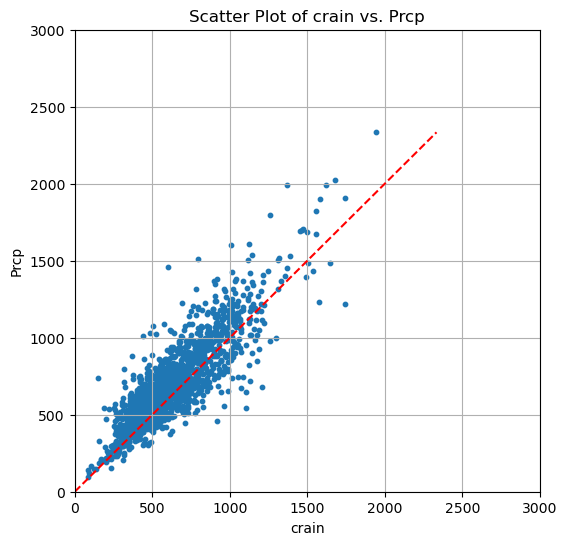

In [7]:
import matplotlib.pyplot as plt

# 绘制散点图
plt.figure(figsize=(6, 6))  # 调整图形大小
plt.scatter(grouped_data['crain'], grouped_data['Prcp'], s = 10)  # 调整散点的透明度
max_value = max(grouped_data[['crain', 'Prcp']].max())
plt.title('Scatter Plot of crain vs. Prcp')
plt.xlabel('crain')
plt.ylabel('Prcp')
plt.xlim(0, 3000)  # 设置 x 轴范围
plt.ylim(0, 3000)  # 设置 y 轴范围
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--')  # 添加对角线
plt.grid(True)
plt.show()


##### 年尺度相对误差计算

In [8]:
# 计算相对误差
grouped_data['Relative_Error'] = abs(grouped_data['crain'] - grouped_data['Prcp']) / grouped_data['Prcp']

# 打印计算结果
print(grouped_data['Relative_Error'].mean())

0.16084238300315762


In [9]:
grouped_data[['station','year','Relative_Error']]

Relative_Error_010 = grouped_data[grouped_data['Relative_Error'] <= 0.1]

Relative_Error_010

# 错误写法：a = grouped_data[grouped_data[ 'Relative_Error' < 0.15 ]]

station  year       crain   Prcp  Relative_Error
4      55279  2012  326.943803  325.9        0.003203
6      55279  2014  350.811421  320.8        0.093552
8      55279  2016  425.632187  434.2        0.019732
9      55279  2017  267.775979  249.5        0.073250
13     55294  2009  454.114925  487.1        0.067717
...      ...   ...         ...    ...             ...
1637   57007  2013  572.669984  579.7        0.012127
1638   57007  2014  381.552491  399.4        0.044686
1643   57007  2019  470.586174  513.1        0.082857
1646   57008  2010  460.976227  483.5        0.046585
1649   57008  2013  554.491445  554.7        0.000376

[618 rows x 5 columns]

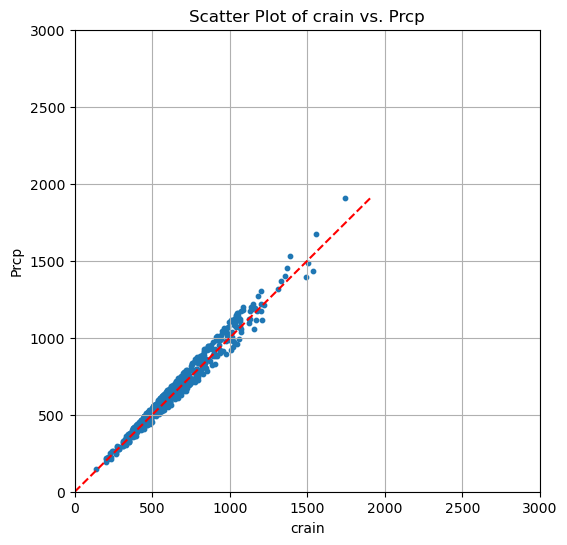

In [10]:
import matplotlib.pyplot as plt

# 绘制散点图
plt.figure(figsize=(6, 6))  # 调整图形大小
plt.scatter(Relative_Error_010['crain'], Relative_Error_010['Prcp'], s = 10)  # 调整散点的透明度
max_value = max(Relative_Error_010[['crain', 'Prcp']].max())
plt.title('Scatter Plot of crain vs. Prcp')
plt.xlabel('crain')
plt.ylabel('Prcp')
plt.xlim(0, 3000)  # 设置 x 轴范围
plt.ylim(0, 3000)  # 设置 y 轴范围
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--')  # 添加对角线
plt.grid(True)
plt.show()

In [37]:
raw_daily_sum = pd.read_csv( path / 'rawP_year_sum.csv')

raw_daily_sum

# 将 DailyP 中的 station 列转换为字符串，保留整数部分
raw_daily_sum['station'] = raw_daily_sum['station'].astype(str).str.split('.').str[0]

In [42]:
# 将 DailyP 中的 Prcp 值匹配到 HoursP_1000 中
match = pd.merge(Relative_Error_010, raw_daily_sum, on=['station', 'year'], how='left')

match.drop(['Unnamed: 0'], axis=1, inplace=True)

match.rename(columns={'Prcp_x': 'Prcp_match', 'Prcp_y': 'Prcp_raw'}, inplace=True)

match

station  year       crain  Prcp_match  Relative_Error  Prcp_raw
0     55279  2012  326.943803       325.9        0.003203     328.8
1     55279  2014  350.811421       320.8        0.093552     350.6
2     55279  2016  425.632187       434.2        0.019732     479.6
3     55279  2017  267.775979       249.5        0.073250     432.1
4     55294  2009  454.114925       487.1        0.067717     500.6
..      ...   ...         ...         ...             ...       ...
613   57007  2013  572.669984       579.7        0.012127     588.8
614   57007  2014  381.552491       399.4        0.044686     454.8
615   57007  2019  470.586174       513.1        0.082857     584.3
616   57008  2010  460.976227       483.5        0.046585     483.5
617   57008  2013  554.491445       554.7        0.000376     564.2

[618 rows x 6 columns]

In [43]:
# 计算相对误差
match['Prcp_RE'] = abs(match['Prcp_match'] - match['Prcp_raw']) / match['Prcp_raw']

# 打印计算结果
print(match['Prcp_RE'].mean())

0.0765850866014115


##### 相对误差小于 0.1 次数统计

In [11]:
station_counts = Relative_Error_010['station'].value_counts()

# 转换为 DataFrame
station_counts = station_counts.reset_index()

# 重命名列
station_counts.columns = ['station', 'counts']

# 打印统计结果
station_counts

station  counts
0     56251       9
1     56459       9
2     56764       9
3     56097       8
4     56646       8
..      ...     ...
130   56197       1
131   56202       1
132   56227       1
133   56462       1
134   56285       1

[135 rows x 2 columns]

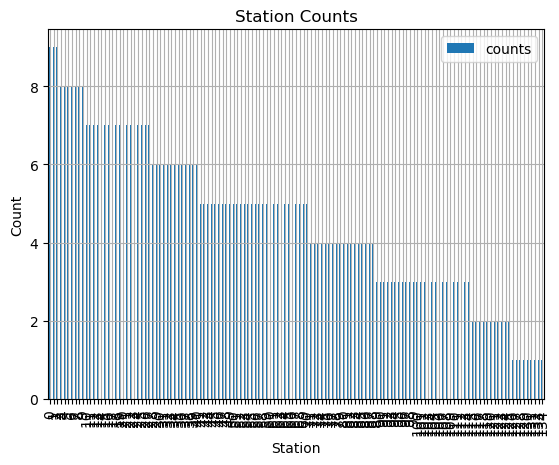

In [12]:
import matplotlib.pyplot as plt

# 假设 station_counts 是包含每个站点出现次数的 Series
# 使用 plot 方法绘制柱状图
station_counts.plot(kind='bar')

# 设置图形标题和轴标签
plt.title('Station Counts')
plt.xlabel('Station')
plt.ylabel('Count')

# 显示网格线
plt.grid(True)

# 显示图形
plt.show()


In [13]:
# 选出 Relative_Error_010 大于等于 6 次 的站点

Relative_Error_010_06 = station_counts[ station_counts['counts'] >= 6 ]

Relative_Error_010_06

# Relative_Error_010_06.to_csv( path / 'Relative_Error_010_06.csv')

station  counts
0    56251       9
1    56459       9
2    56764       9
3    56097       8
4    56646       8
5    56273       8
6    56665       8
7    56144       8
8    56652       8
9    56761       8
10   56116       7
11   56128       7
12   56146       7
13   56664       7
14   56342       7
15   56167       7
16   56263       7
17   56578       7
18   56106       7
19   56487       7
20   56475       7
21   56474       7
22   56443       7
23   56441       7
24   56307       7
25   56312       7
26   56543       7
27   56331       7
28   56669       6
29   56152       6
30   56021       6
31   56473       6
32   56649       6
33   56257       6
34   56670       6
35   56267       6
36   57007       6
37   55593       6
38   56278       6
39   56357       6
40   55299       6

In [14]:
# station_counts.to_csv( path / 'Relative_Error_010_station_counts.csv')

### 2.3 日尺度

#### 2.3.1 全局日尺度

In [15]:
import pandas as pd

# 排除 crain 为 0 而 Prcp 不为 0 的行，以及 Prcp 为 0 而 crain 不为 0 的行
#merged_data = merged_data[(merged_data['crain'] == 0) & (merged_data['Prcp'] == 0) | (merged_data['crain'] != 0) & (merged_data['Prcp'] != 0)]


# 输出筛选后的数据
#merged_data


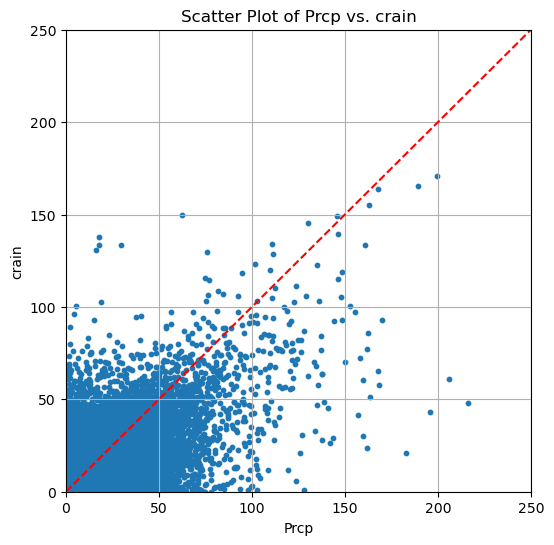

In [16]:
import matplotlib.pyplot as plt

# 绘制散点图
plt.figure(figsize=(6, 6))  # 调整图形大小
plt.scatter(merged_data['Prcp'], merged_data['crain'], s=10)  # 调整散点的透明度
plt.plot([0, 450], [0, 450], color='red', linestyle='--', label='x = y')  # 添加 x=y 的线
plt.title('Scatter Plot of Prcp vs. crain')
plt.xlabel('Prcp')
plt.ylabel('crain')
plt.xlim(0, 250)  # 设置 x 轴范围
plt.ylim(0, 250)  # 设置 y 轴范围
plt.grid(True)
plt.show()



In [17]:
from scipy.stats import pearsonr

# 清洗数据，删除包含 NaN 值的行
cleaned_data = merged_data.dropna()

# 将无穷大值替换为 0
# cleaned_data.replace([np.inf, -np.inf], 0, inplace=True)

# 计算相关系数和 p 值
correlation, p_value = pearsonr(cleaned_data['crain'], cleaned_data['Prcp'])

print("相关系数为:", correlation)
print("显著性 p 值为:", p_value)


相关系数为: 0.6910714825221749
显著性 p 值为: 0.0


In [18]:
# 计算相对误差
merged_data['Relative_Error'] = abs(merged_data['crain'] - merged_data['Prcp']) / merged_data['Prcp']

Relative_Error = merged_data.dropna()

# 打印计算结果
Relative_Error['Relative_Error']

3         1.000000
4              inf
5              inf
7              inf
10        1.000000
            ...   
567383    1.000000
567384    1.000000
567388    0.188066
567389    0.815465
567395    0.255732
Name: Relative_Error, Length: 268578, dtype: float64

In [19]:
# merged_data.to_csv( path / 'merged_data.csv')

##### Grouped by stations

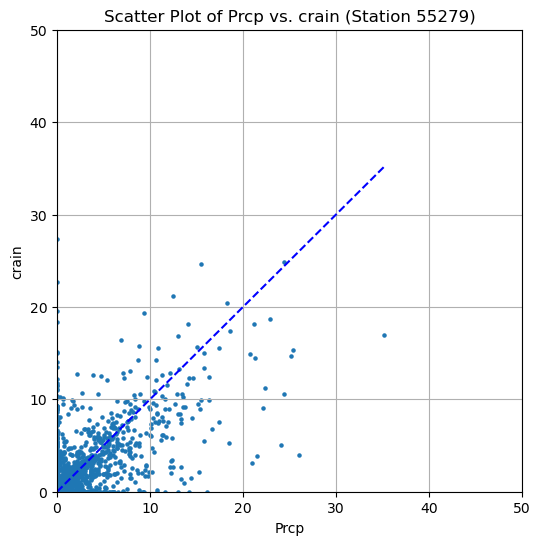

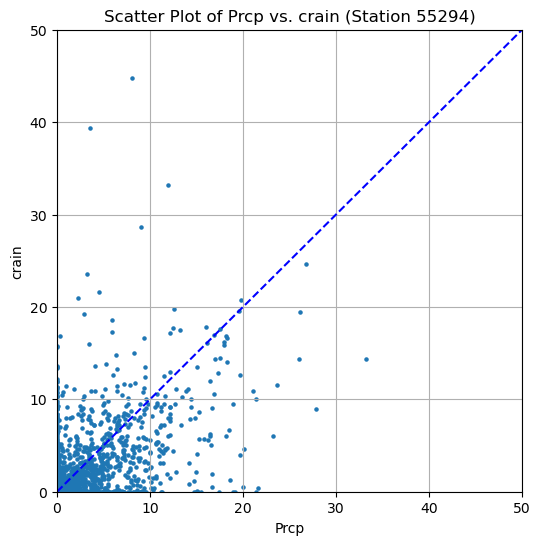

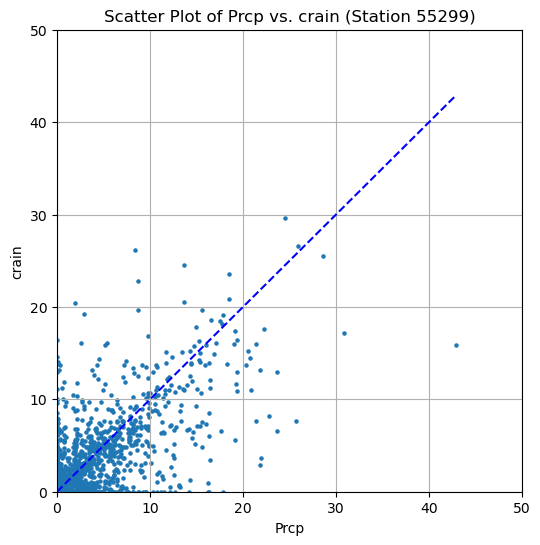

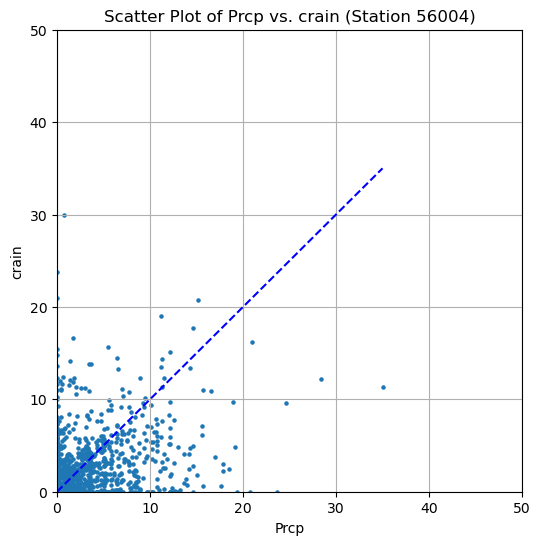

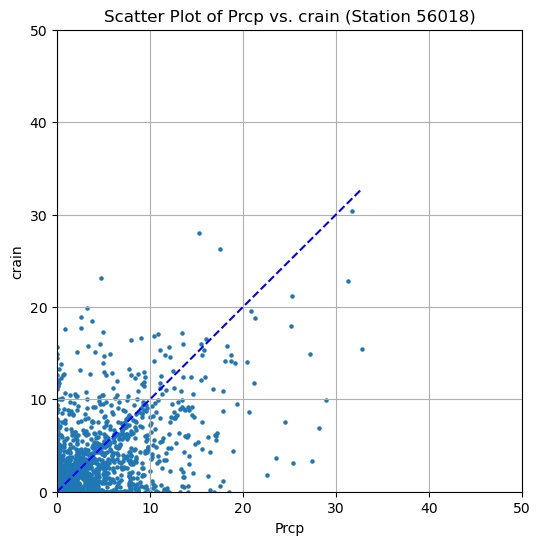

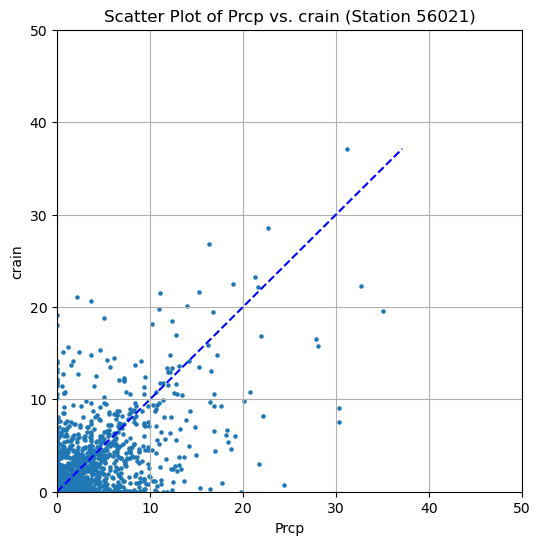

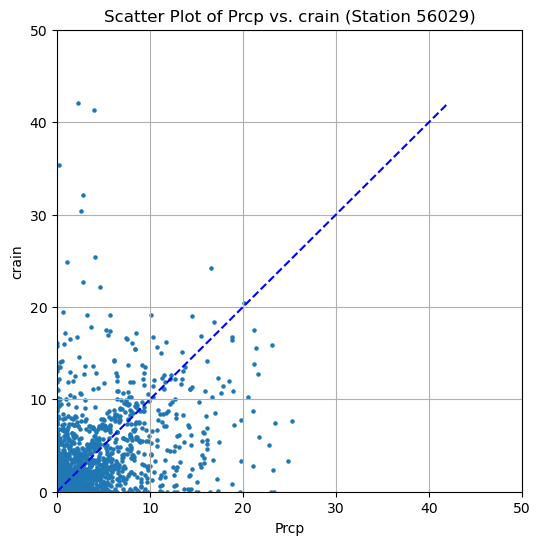

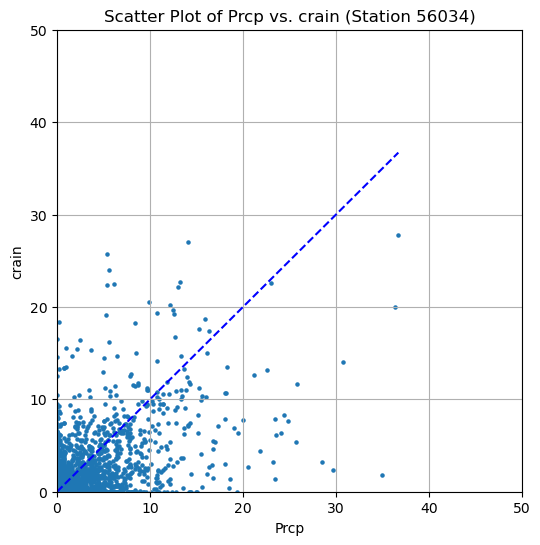

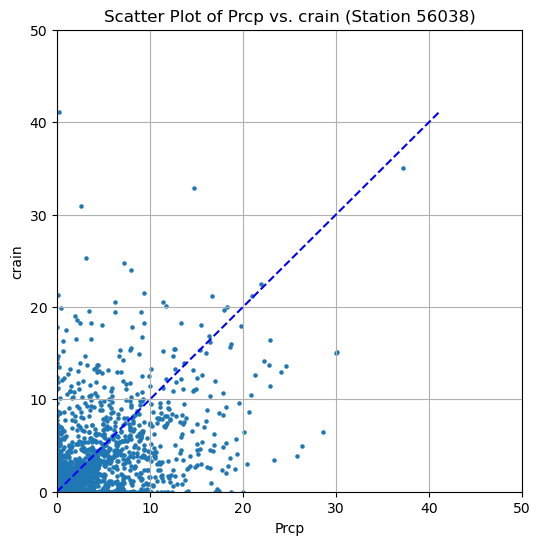

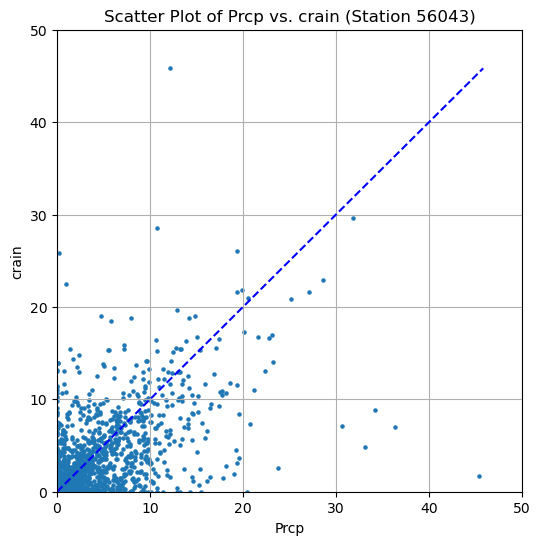

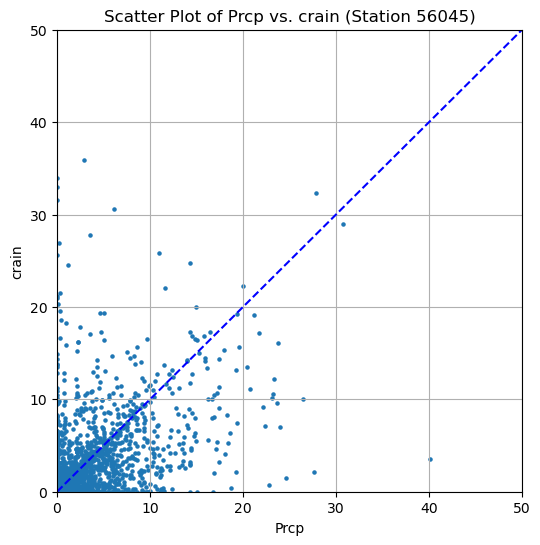

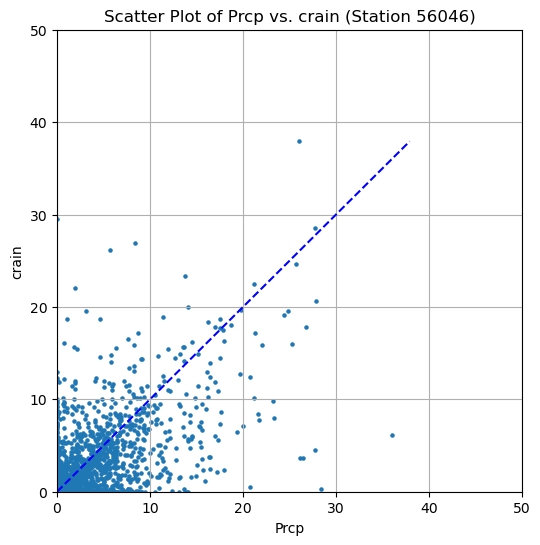

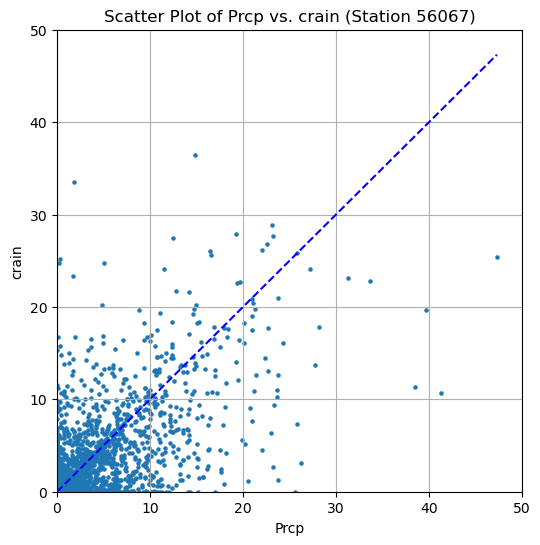

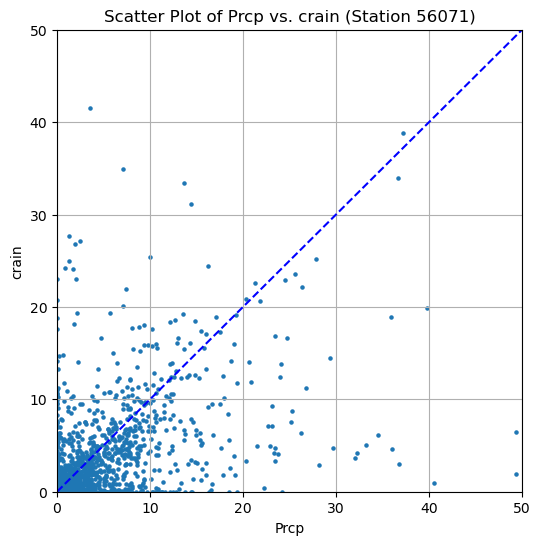

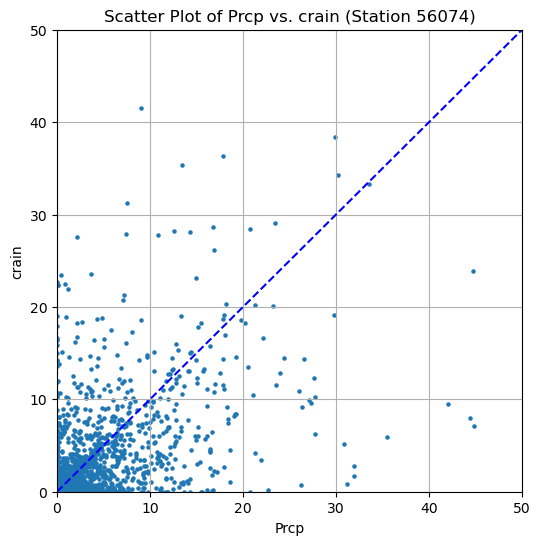

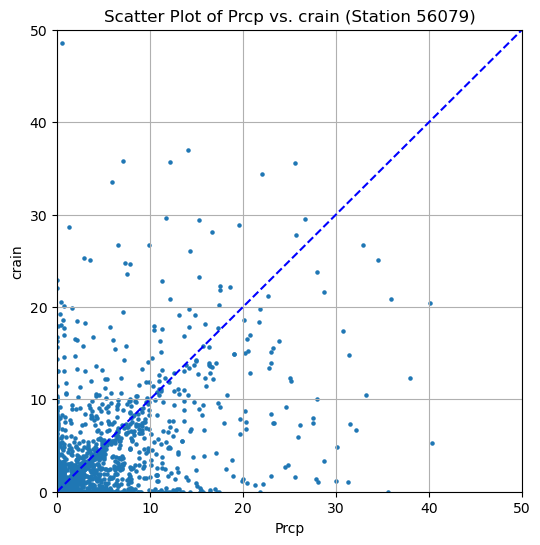

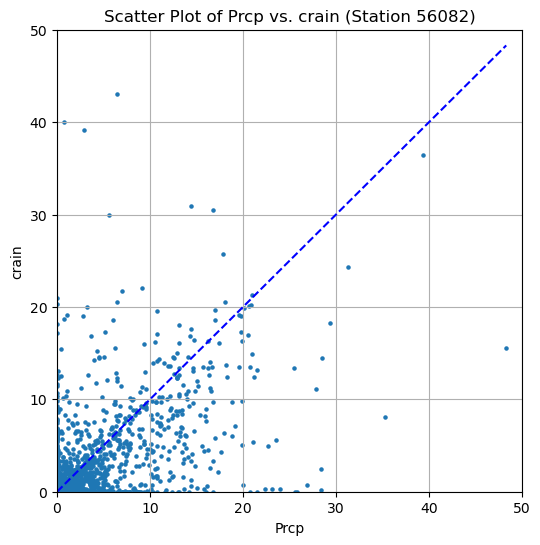

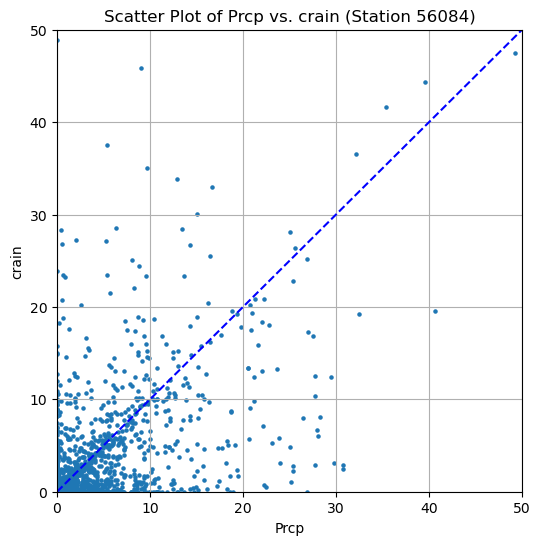

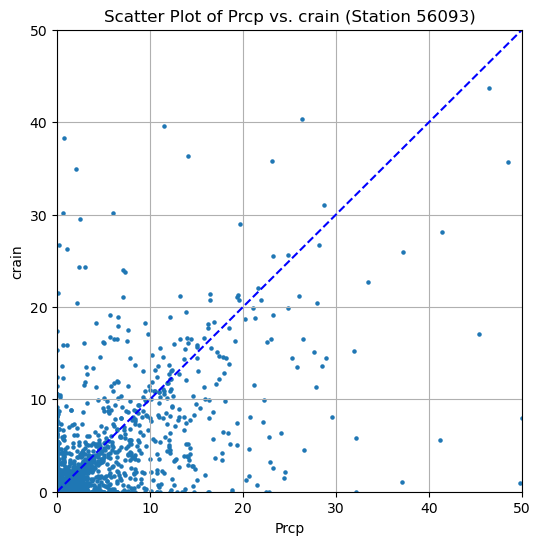

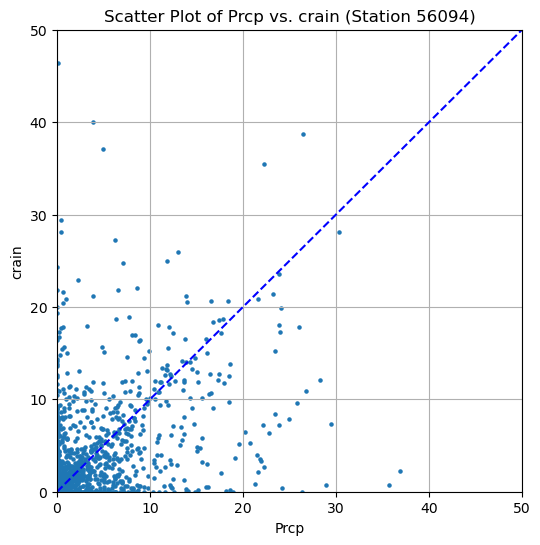

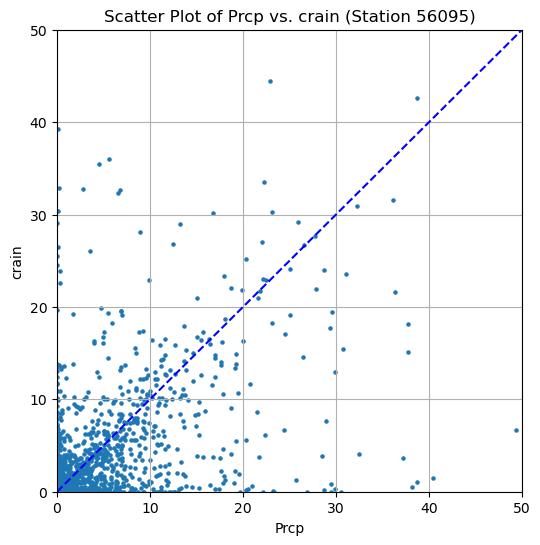

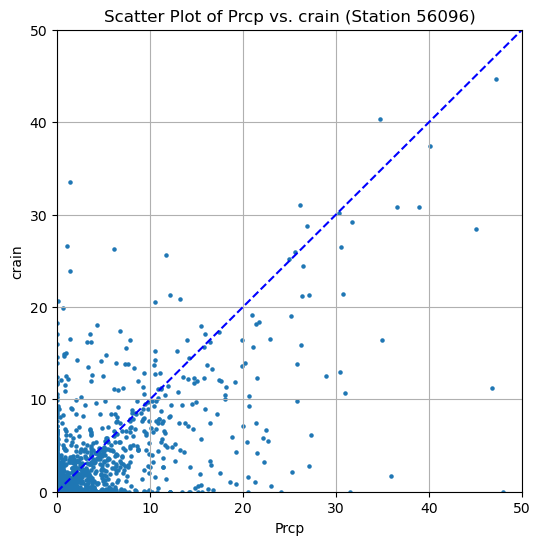

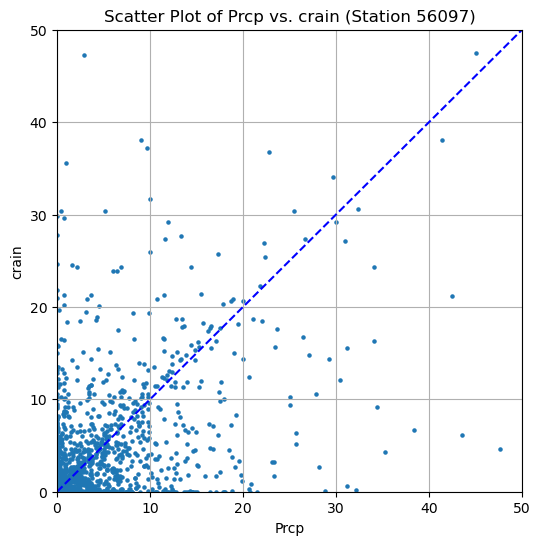

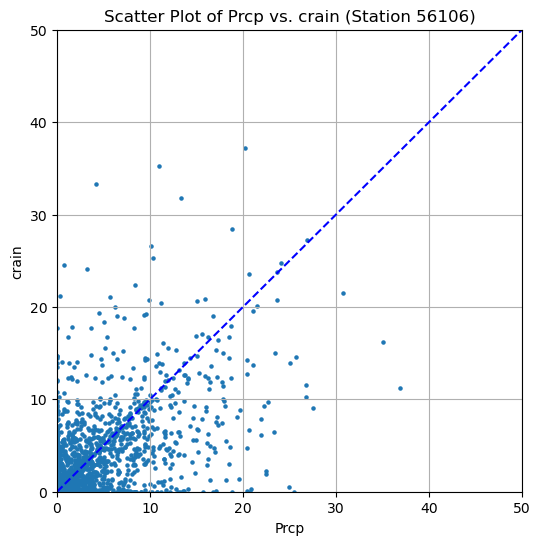

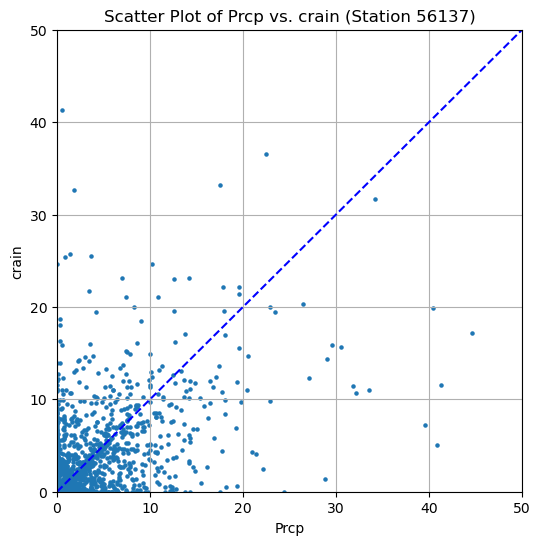

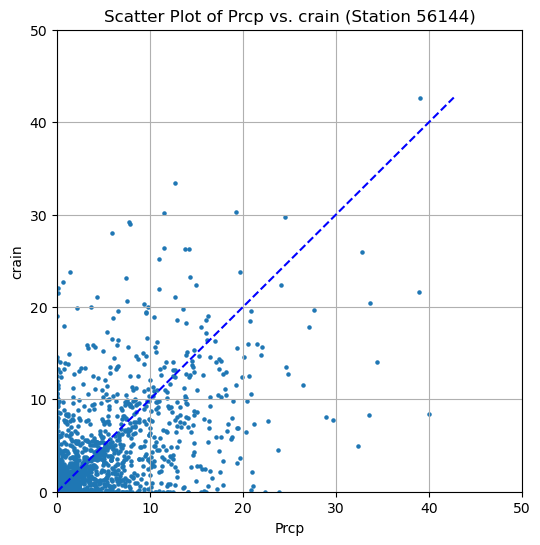

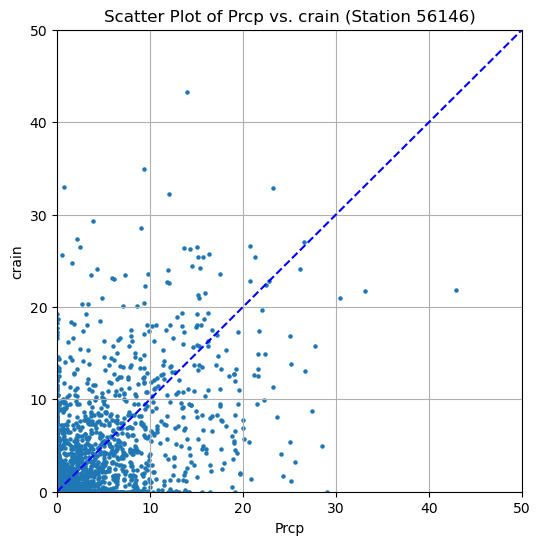

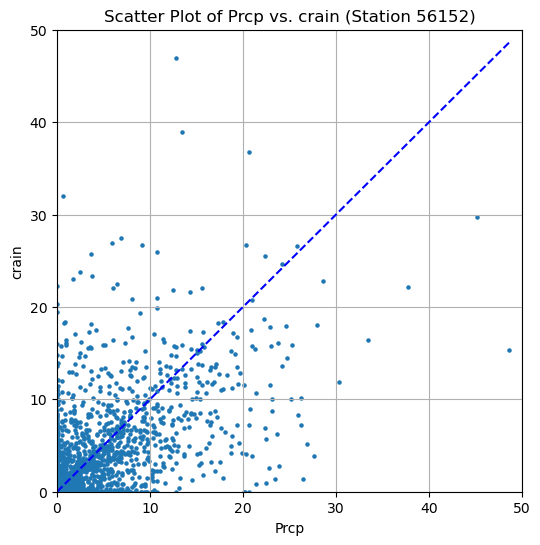

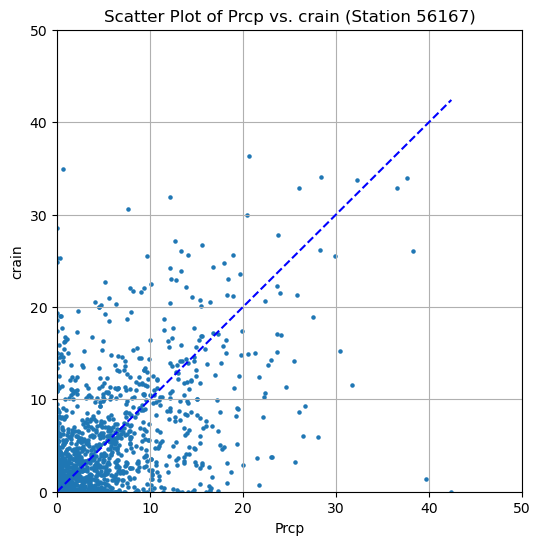

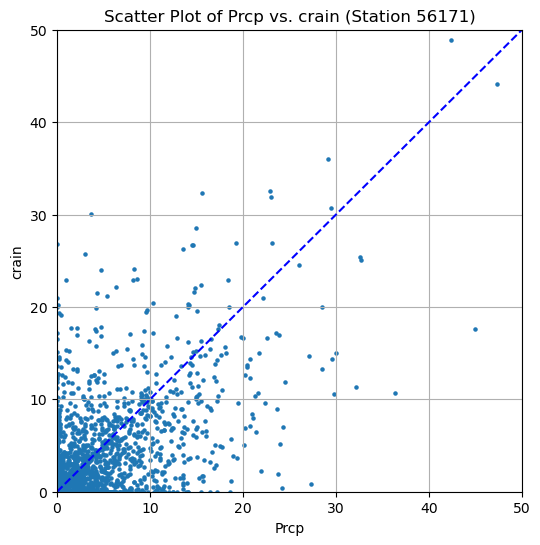

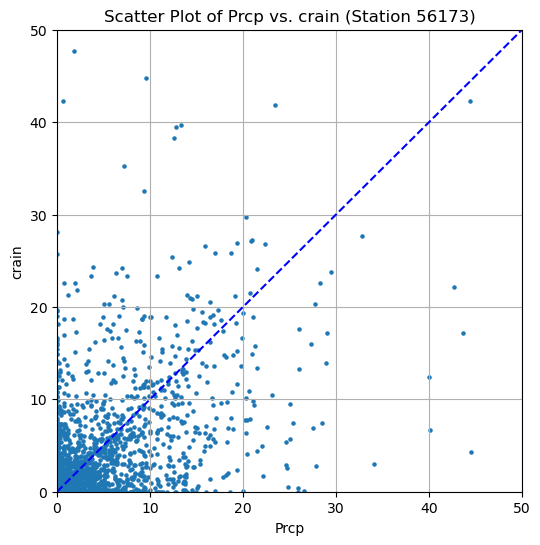

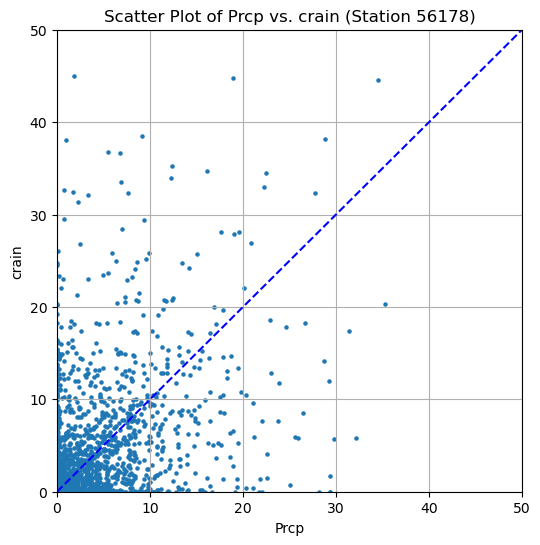

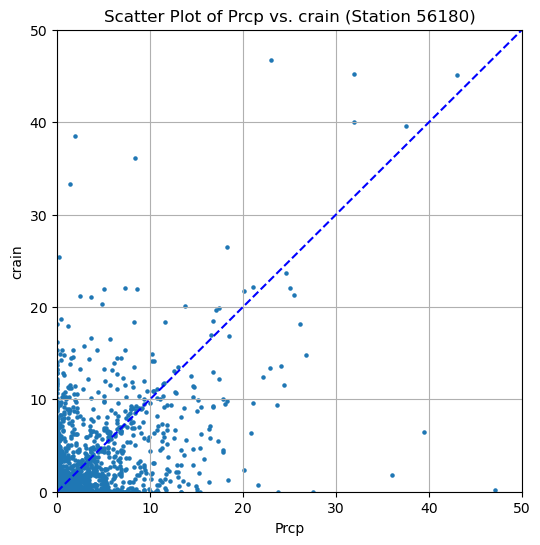

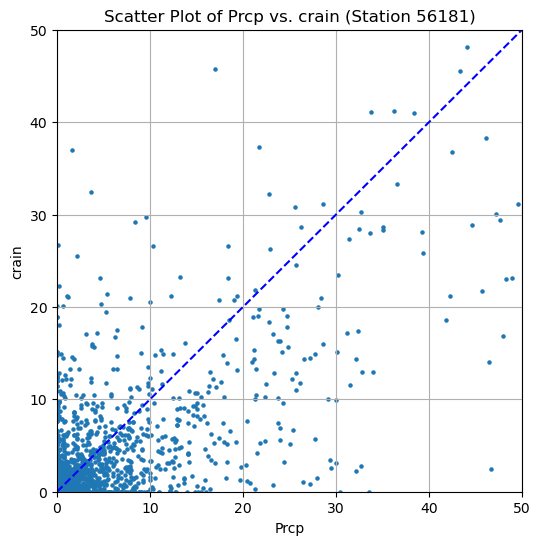

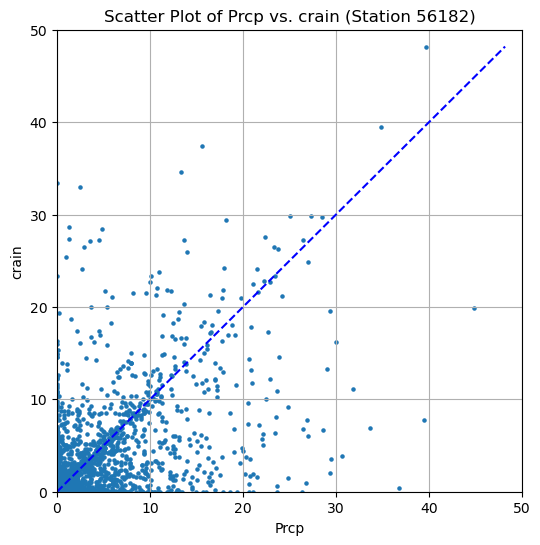

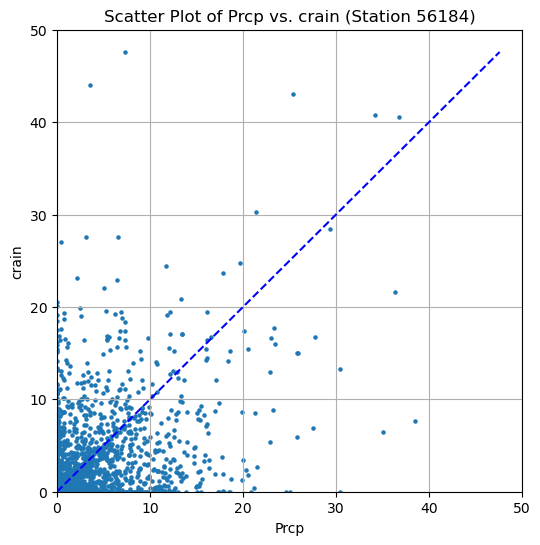

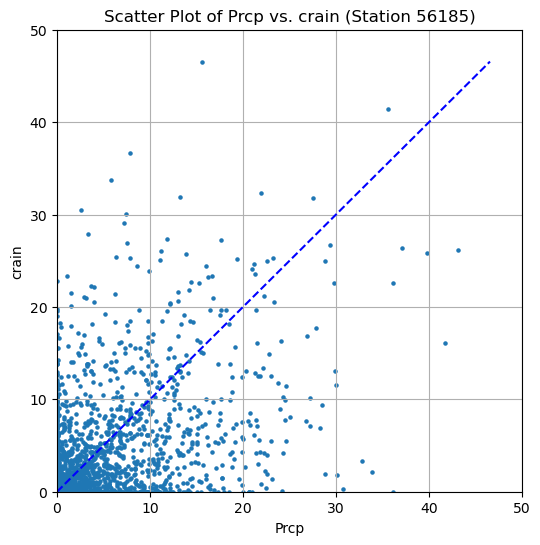

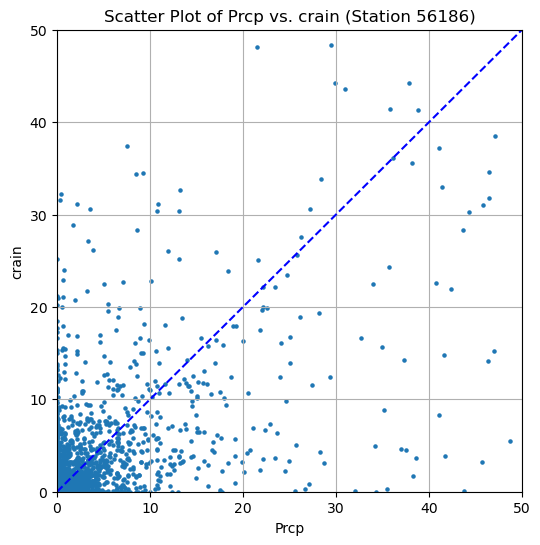

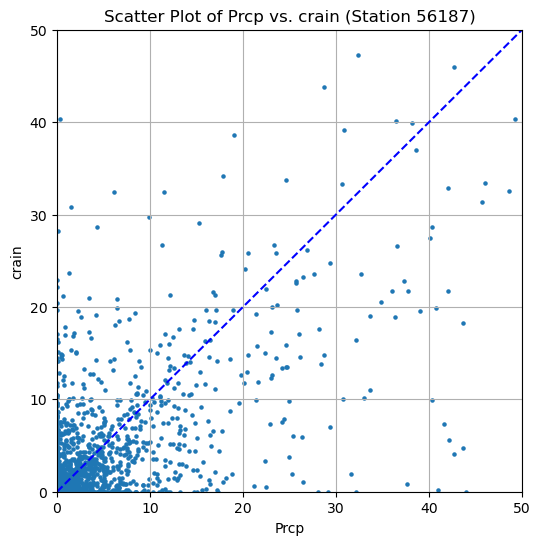

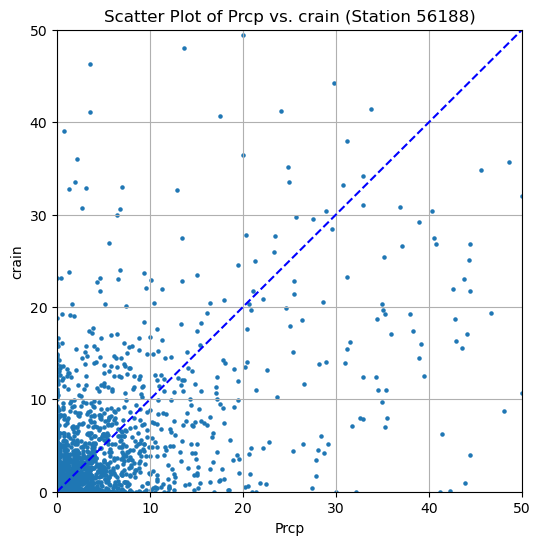

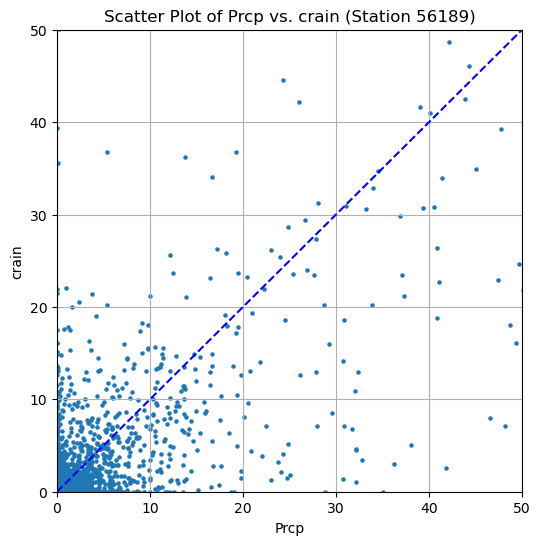

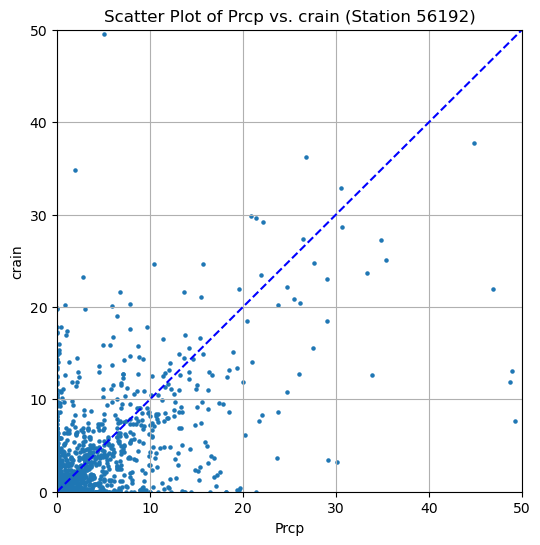

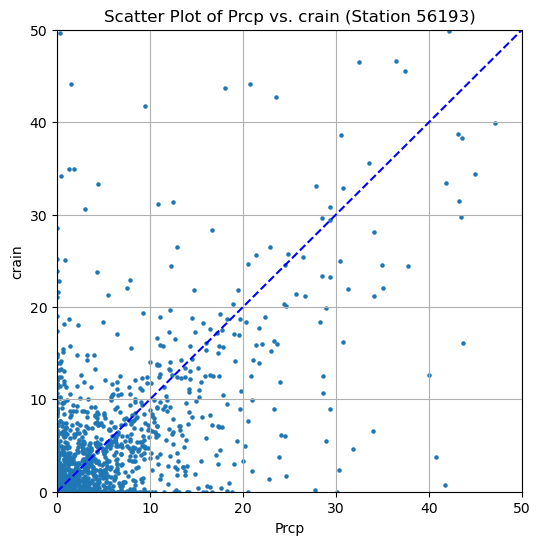

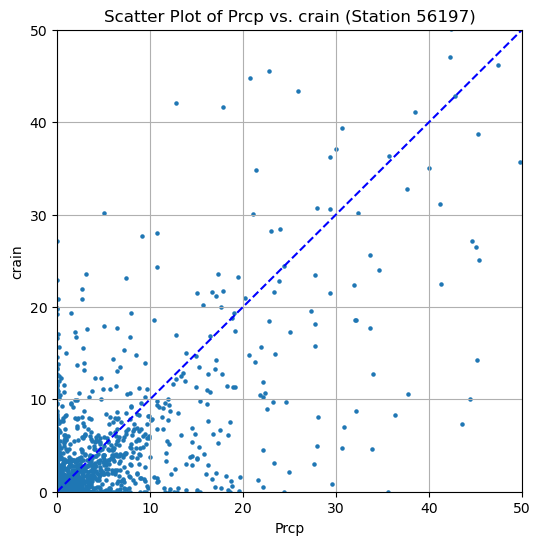

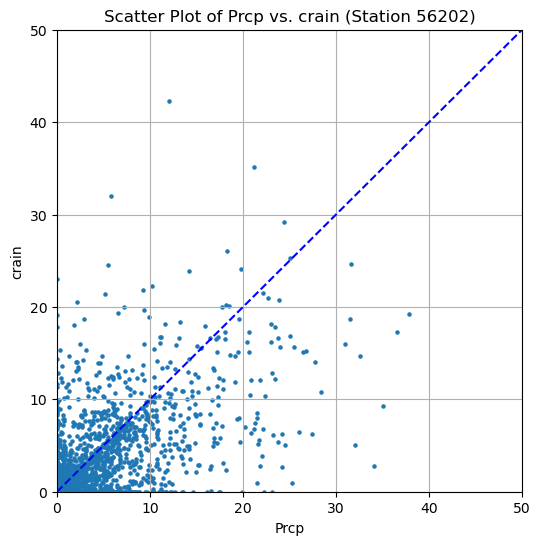

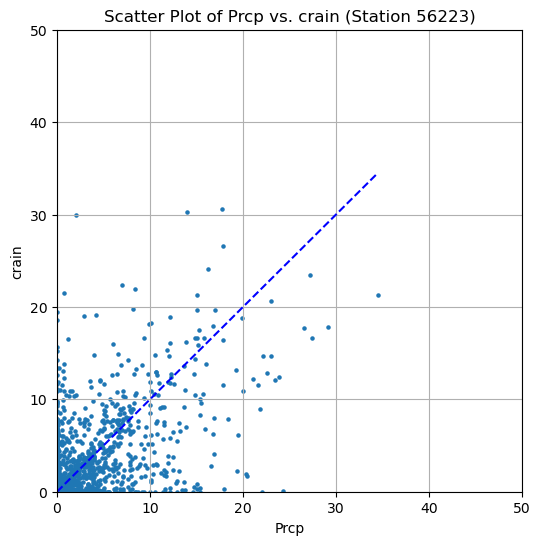

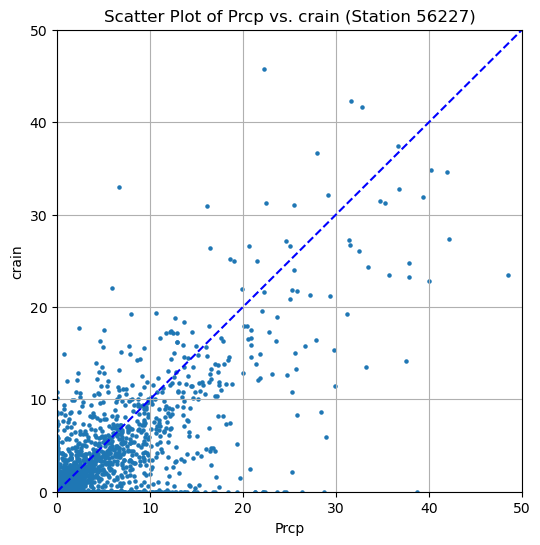

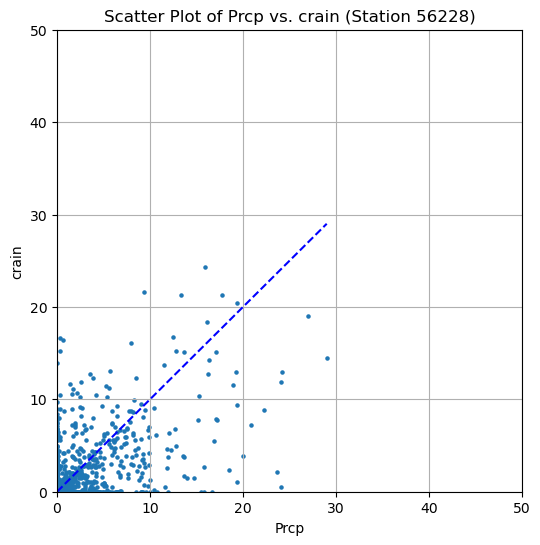

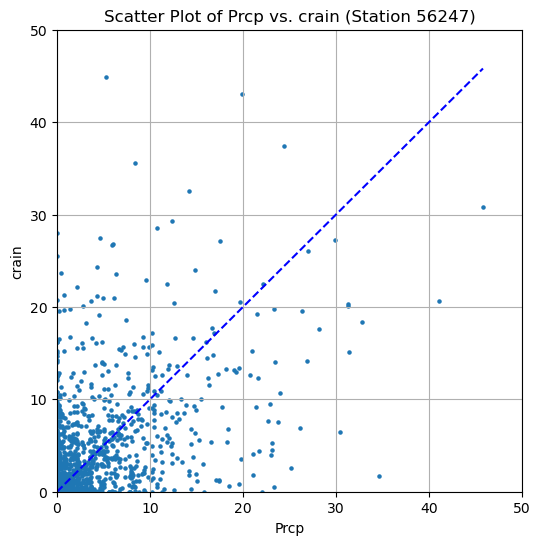

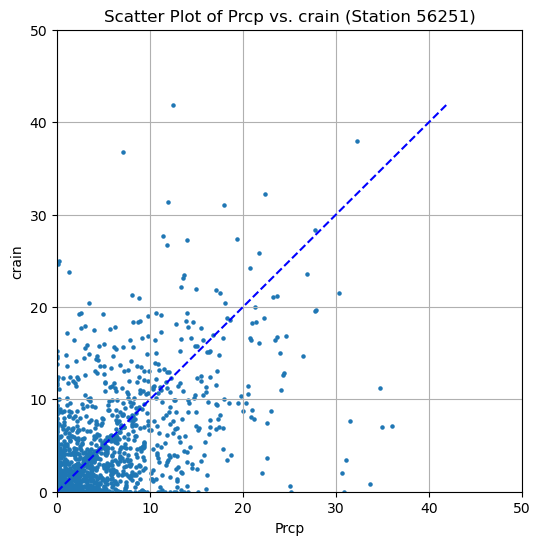

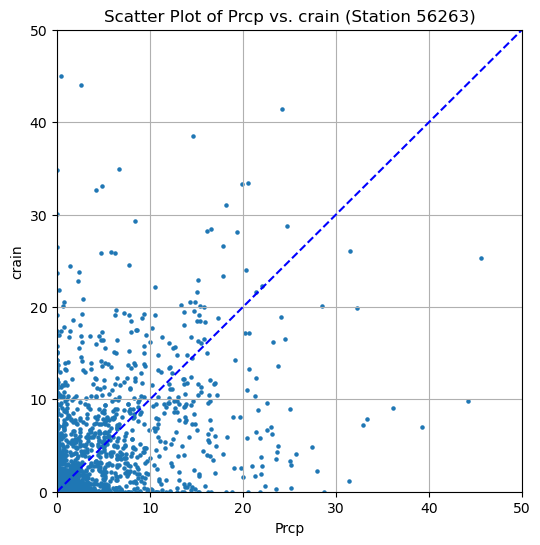

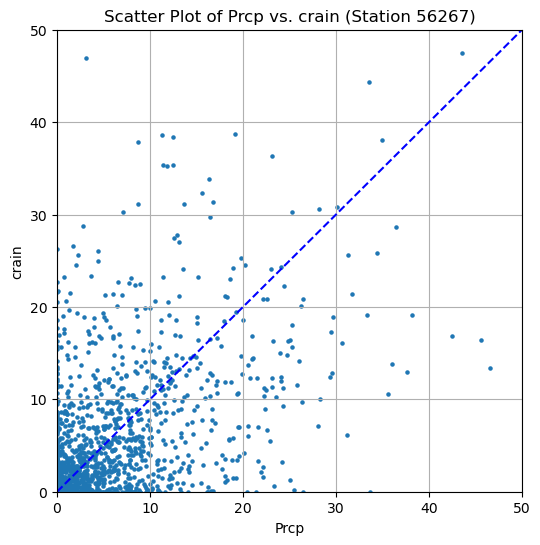

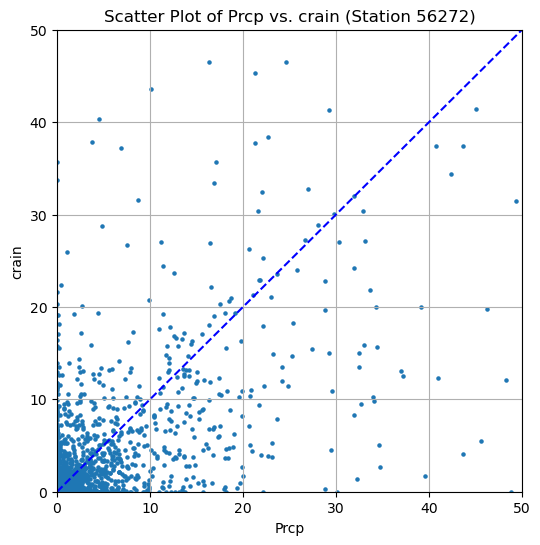

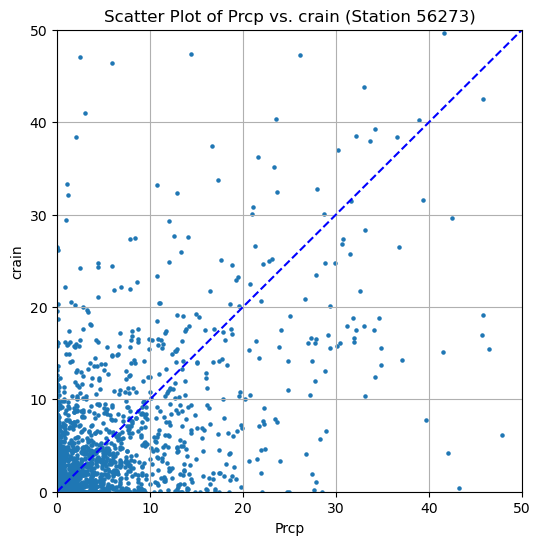

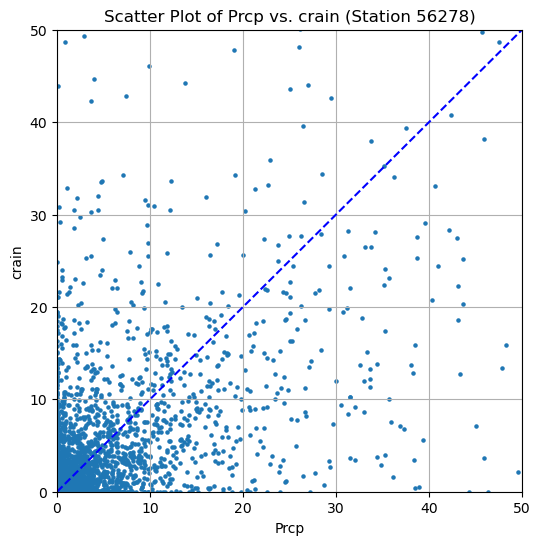

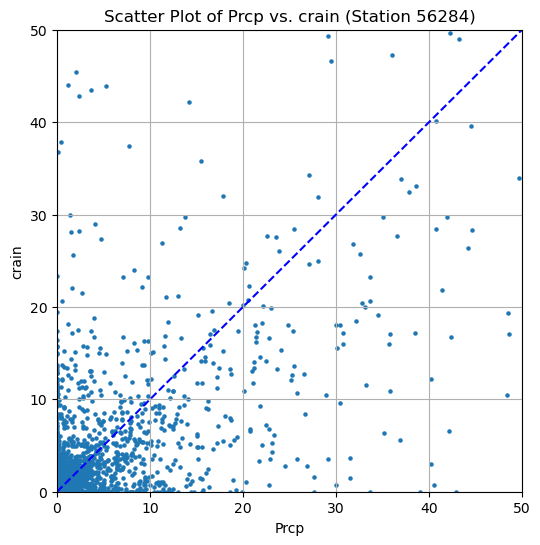

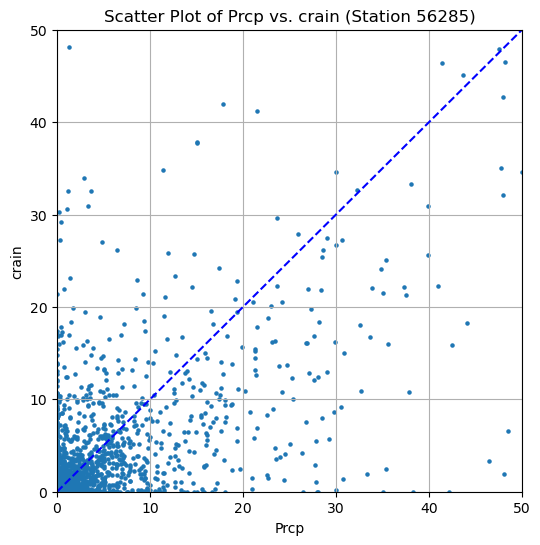

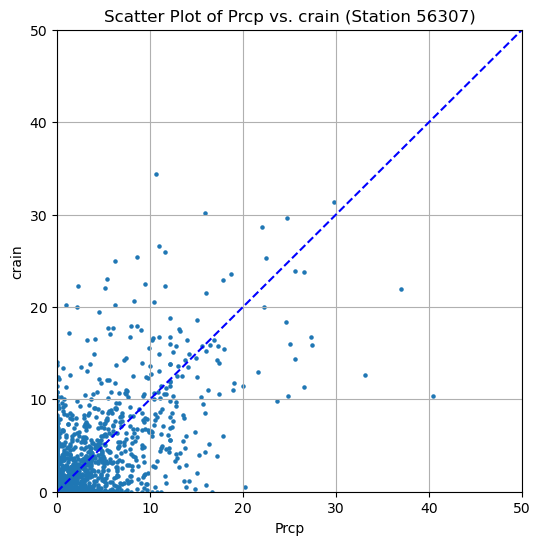

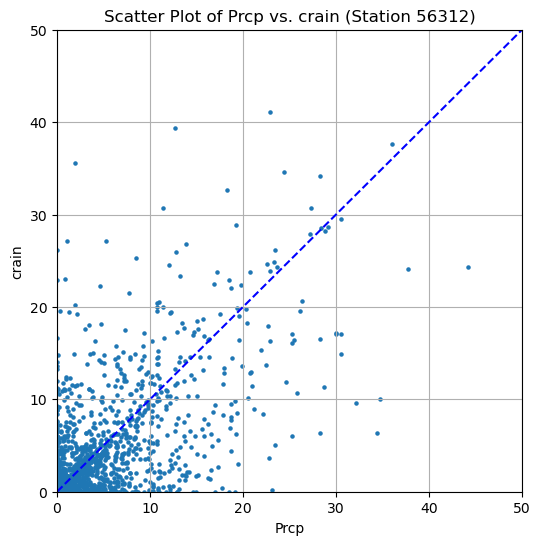

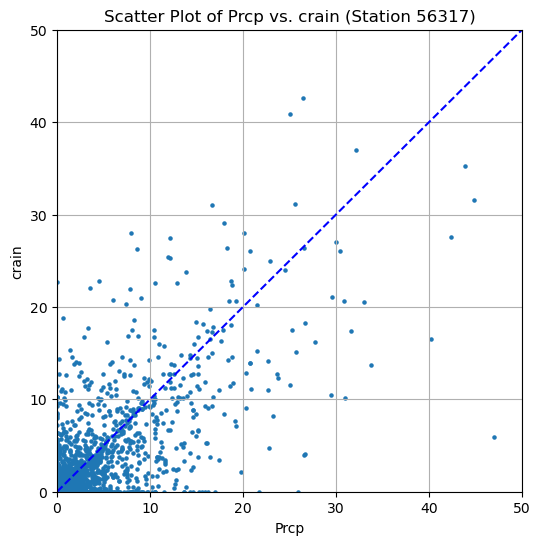

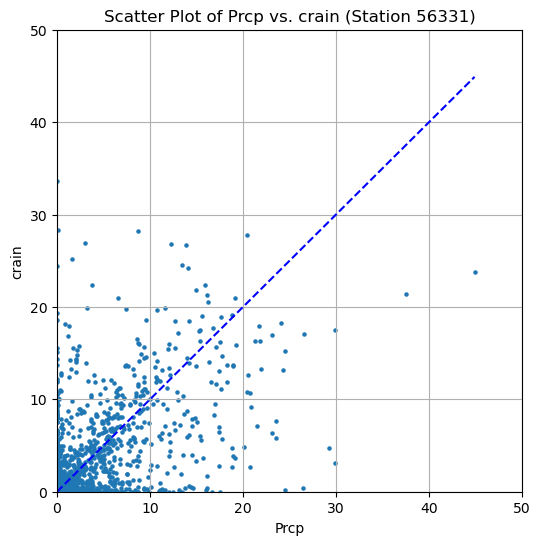

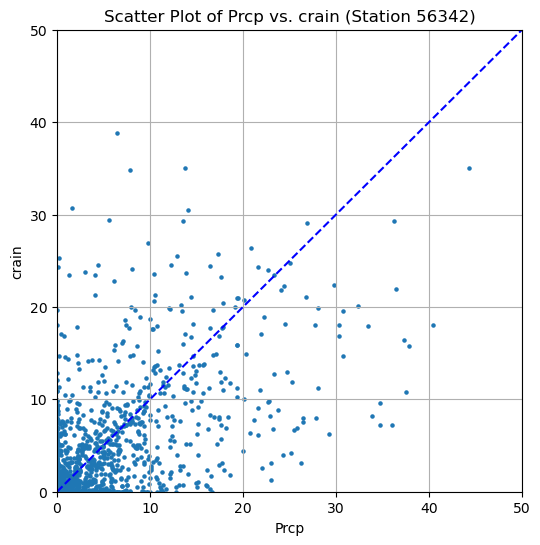

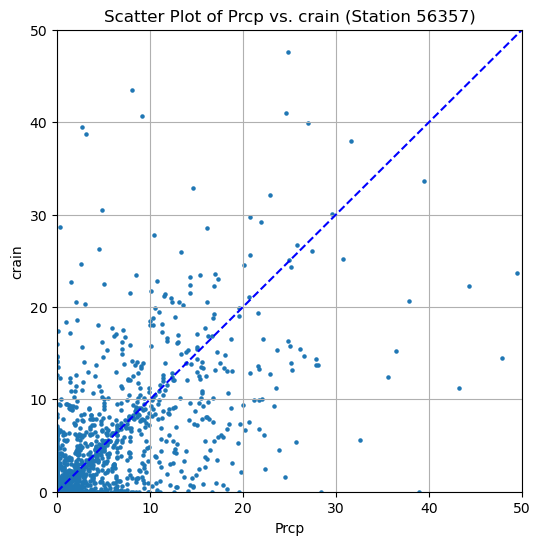

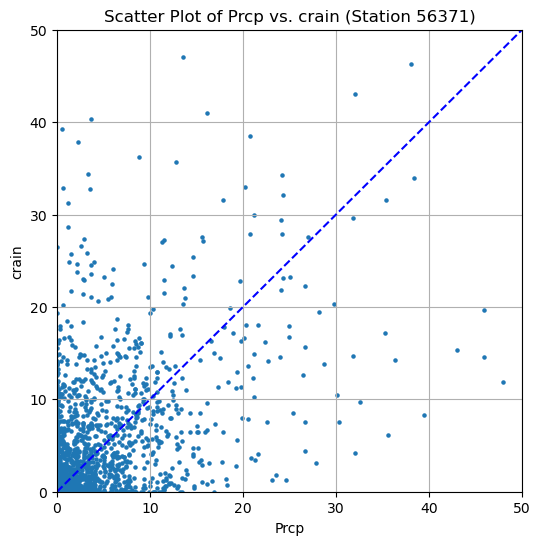

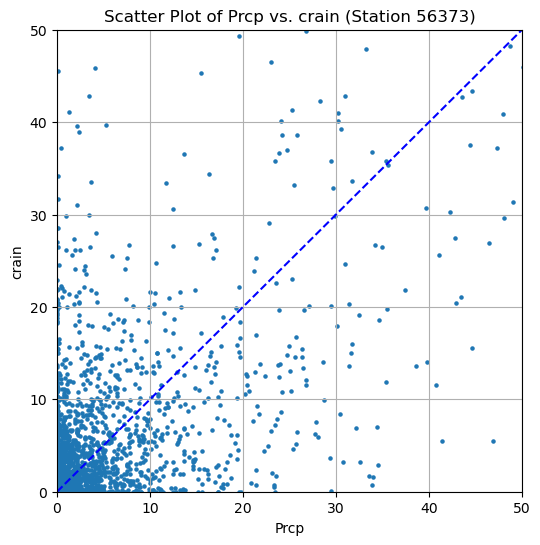

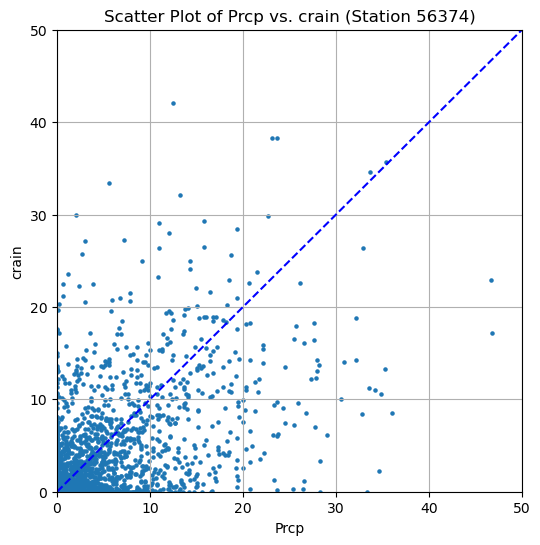

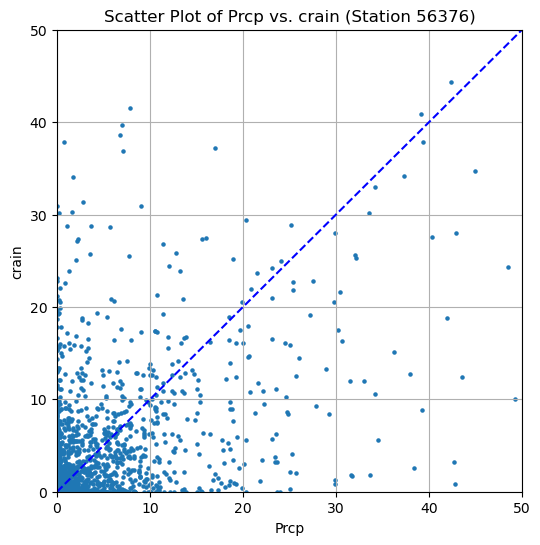

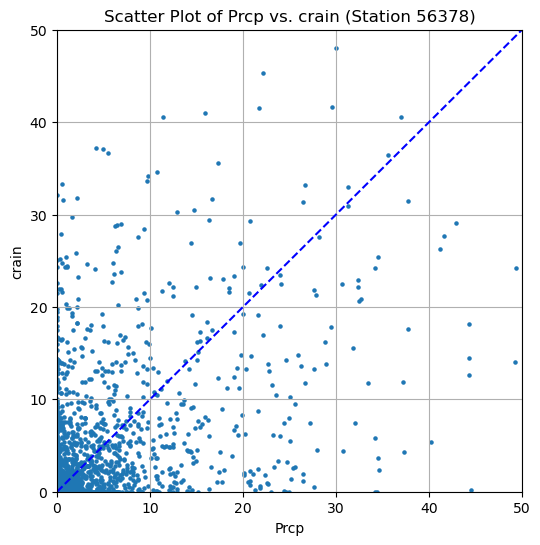

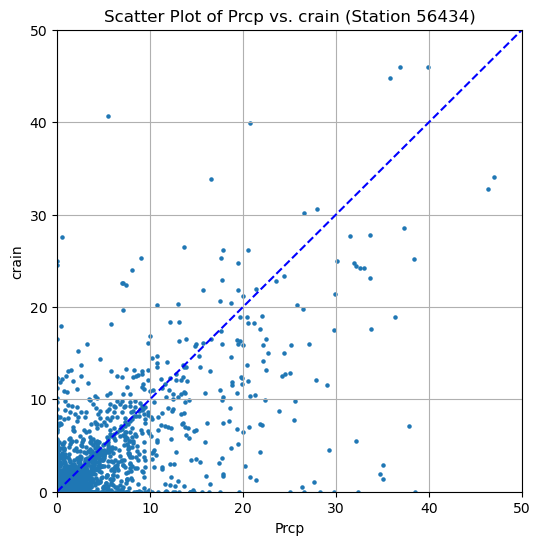

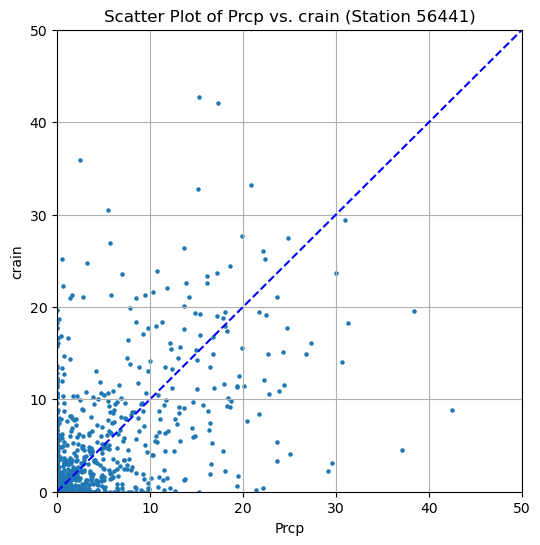

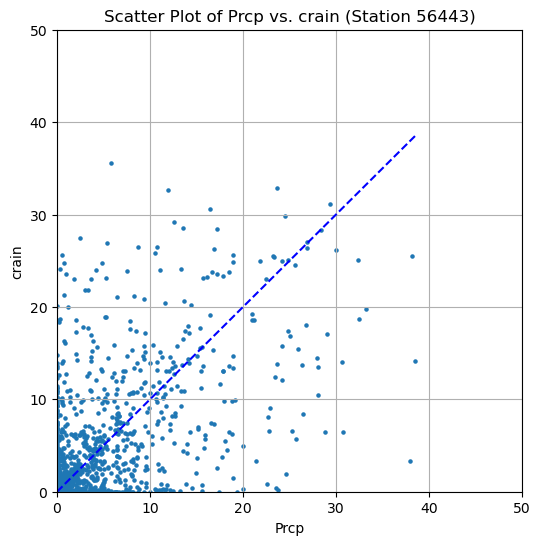

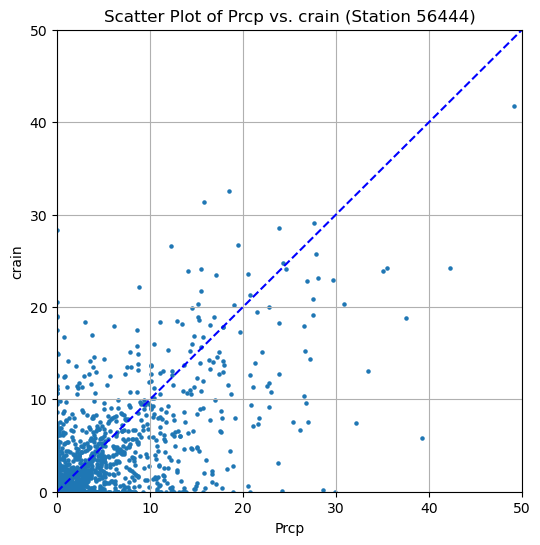

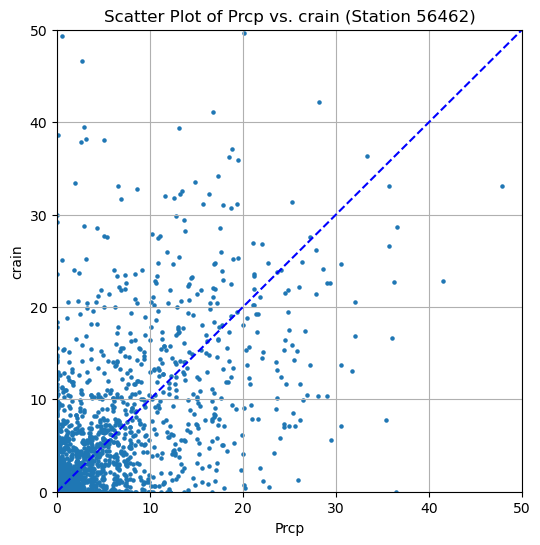

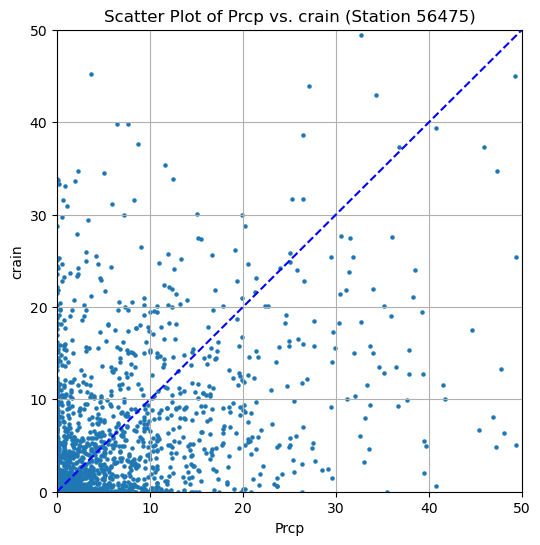

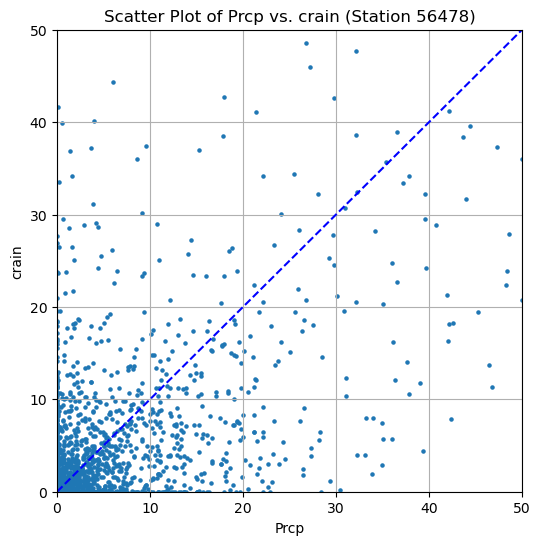

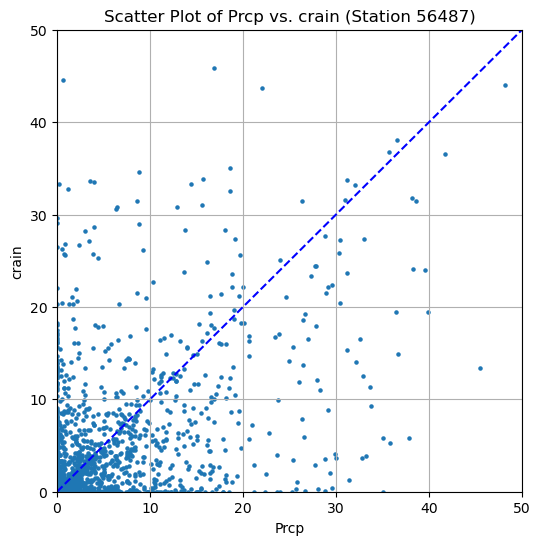

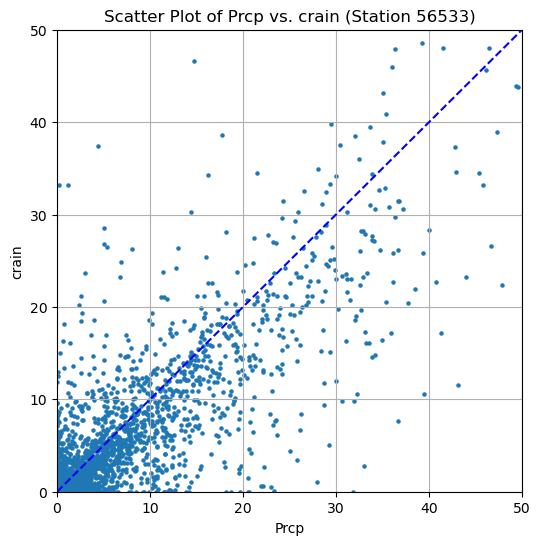

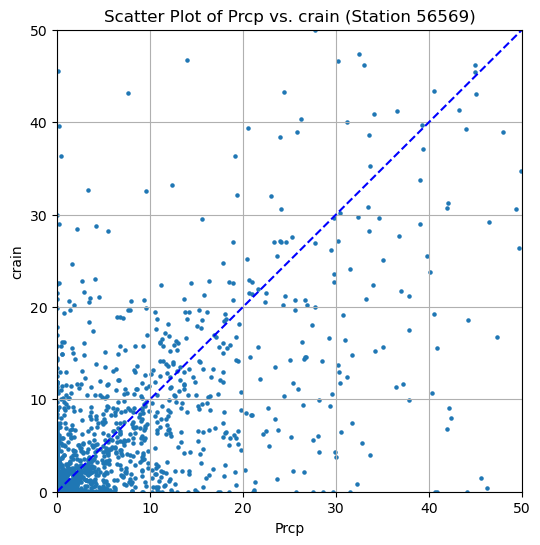

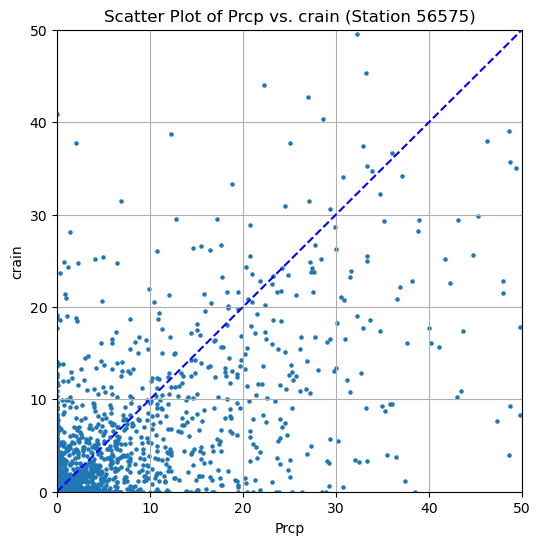

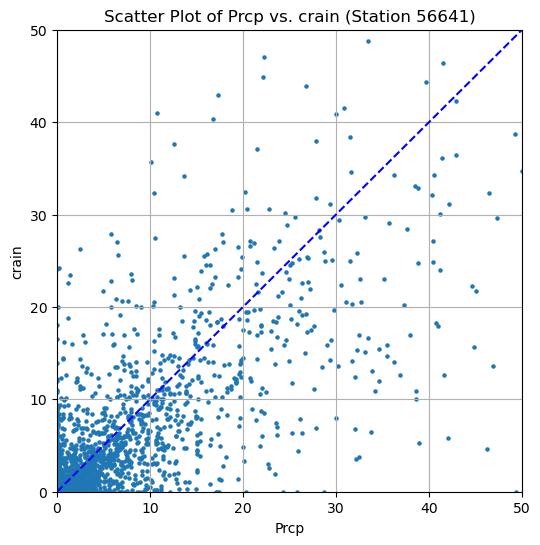

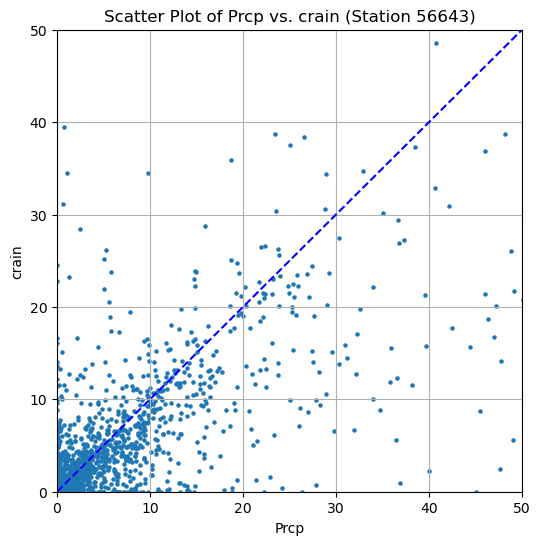

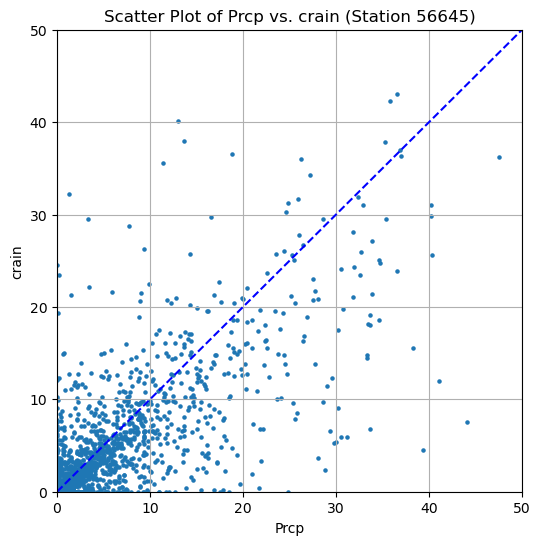

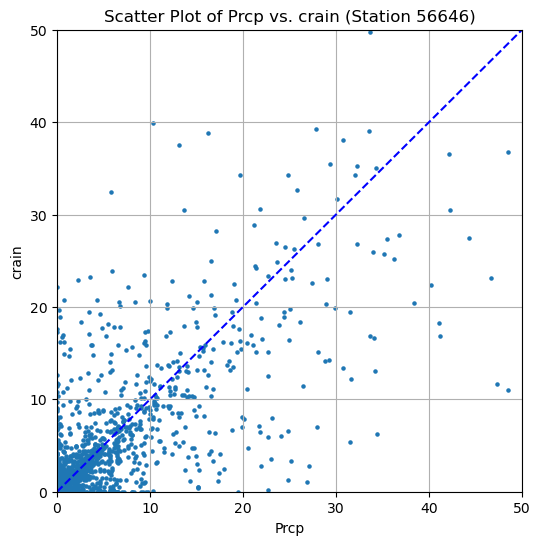

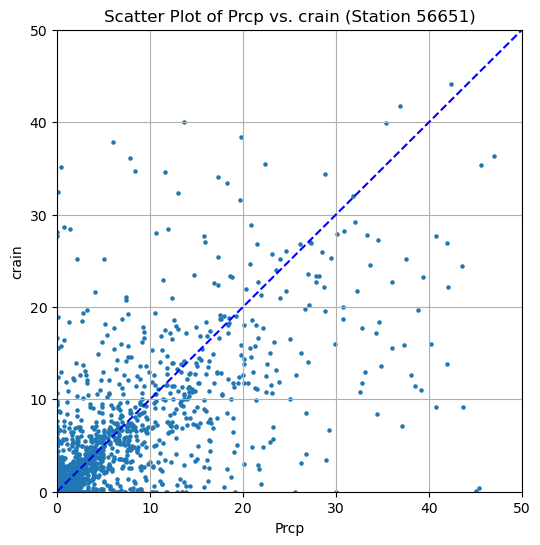

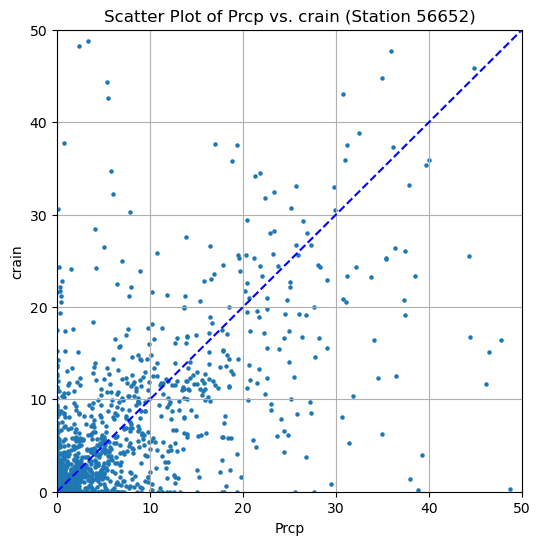

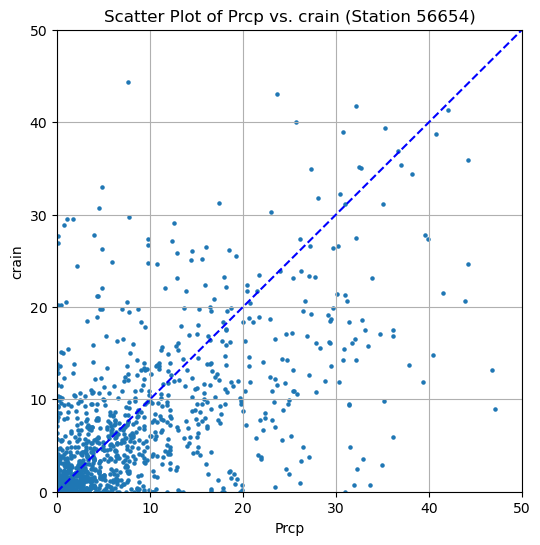

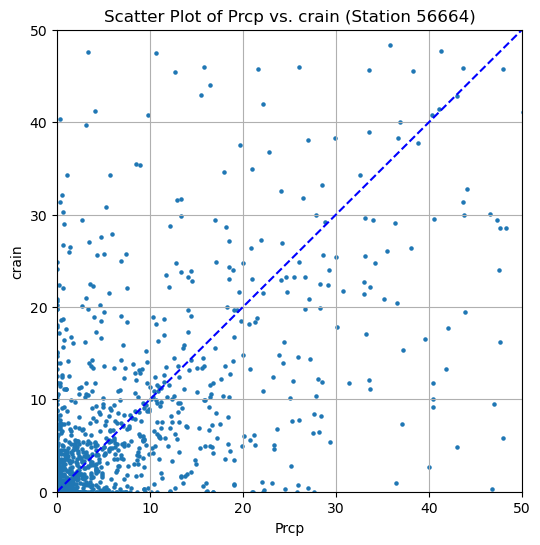

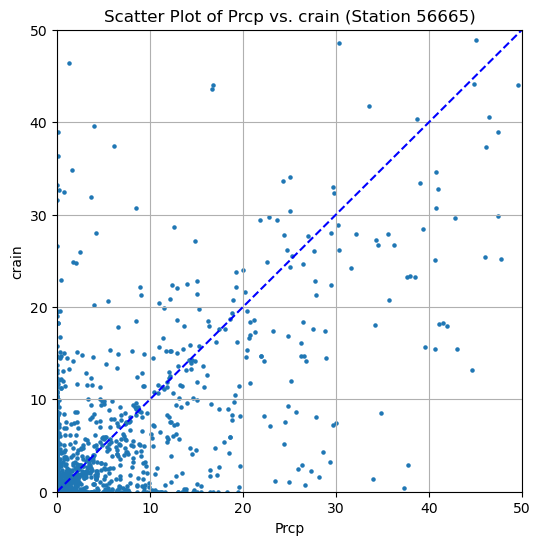

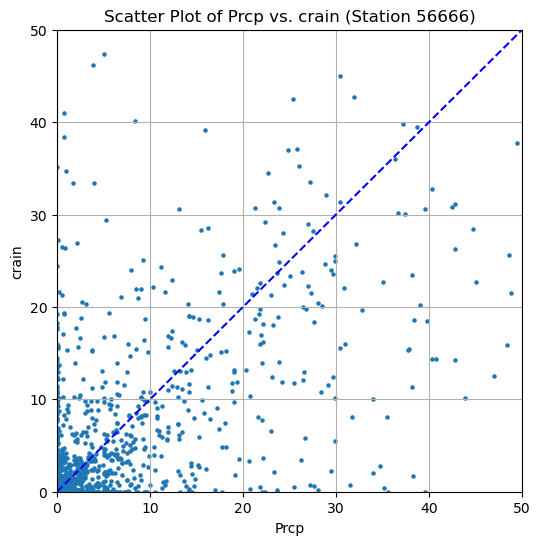

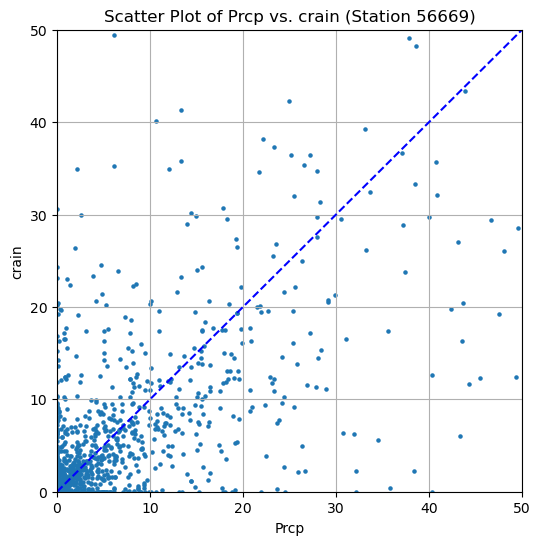

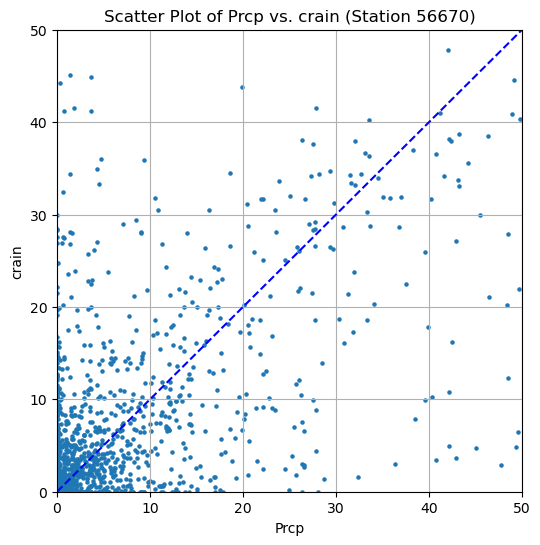

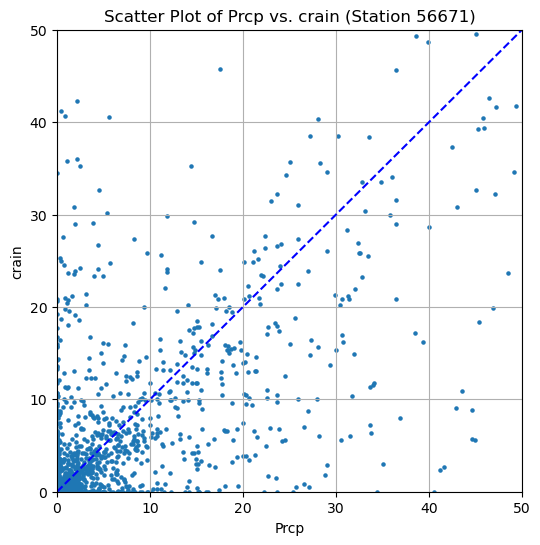

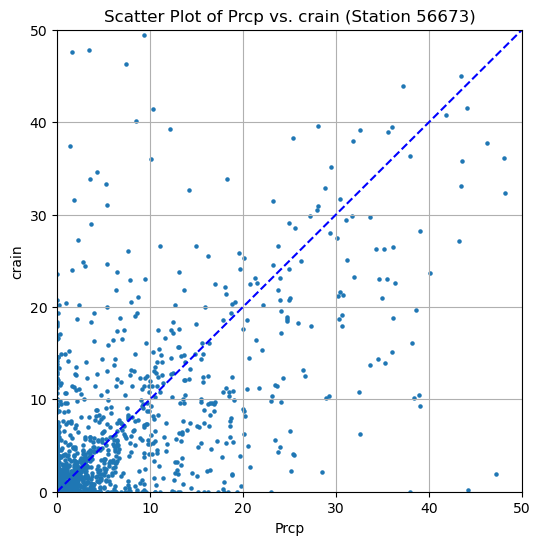

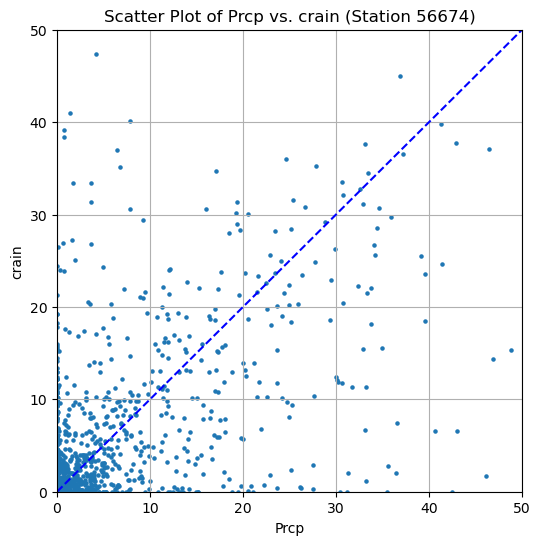

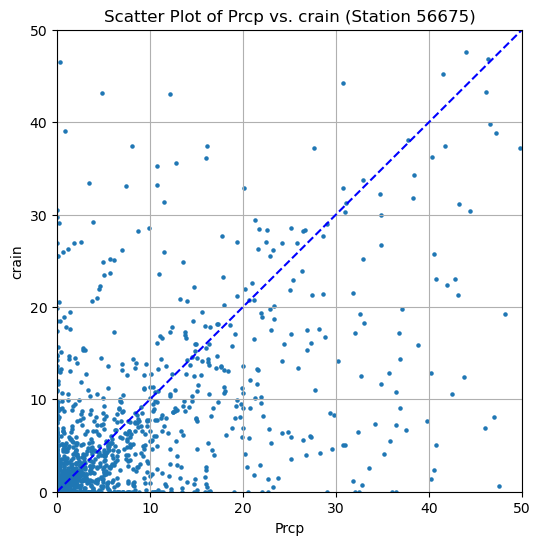

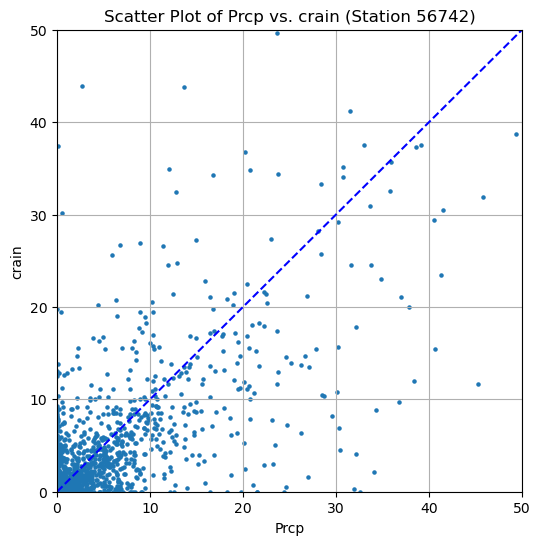

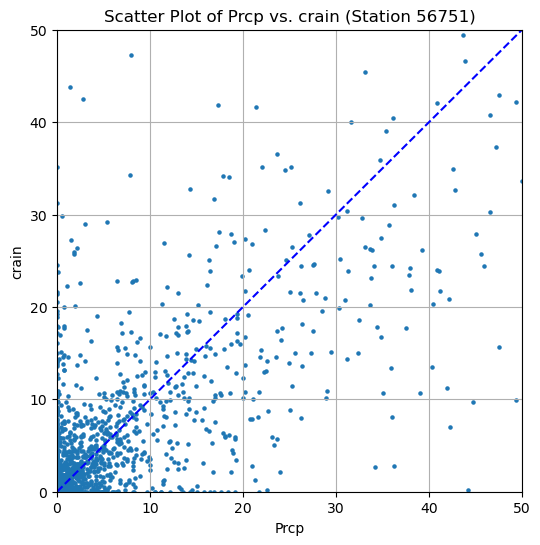

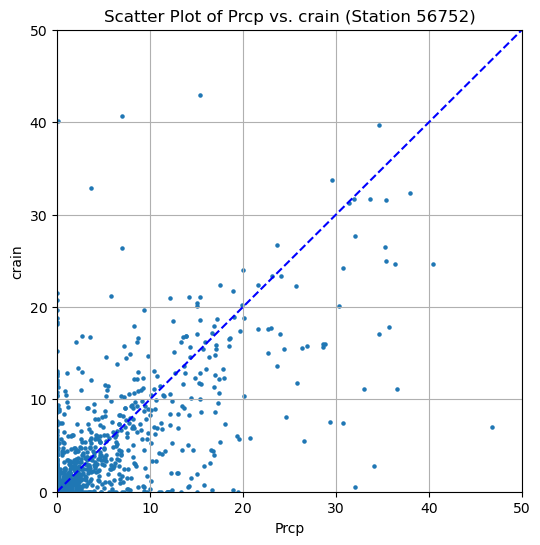

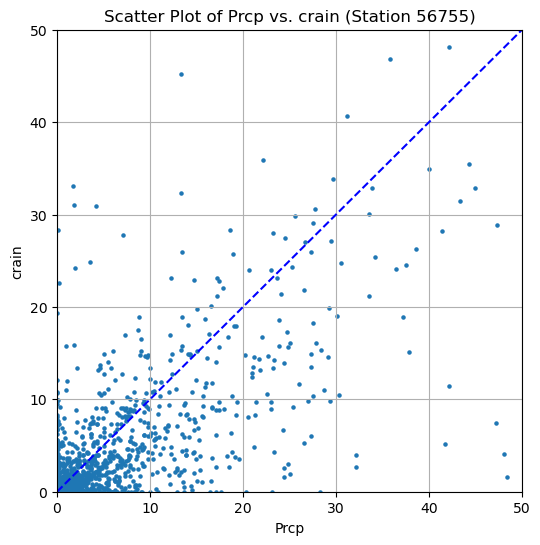

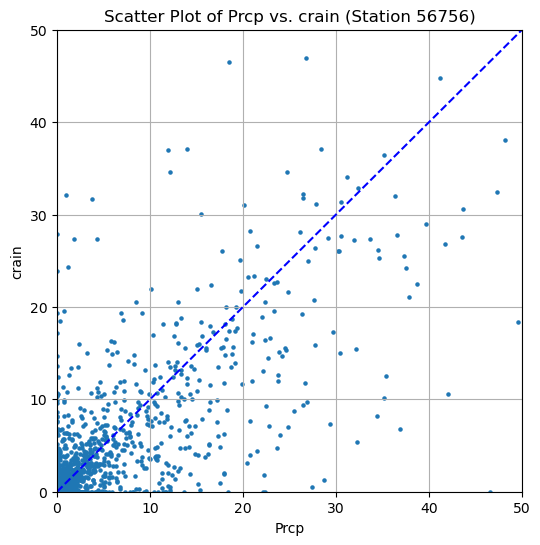

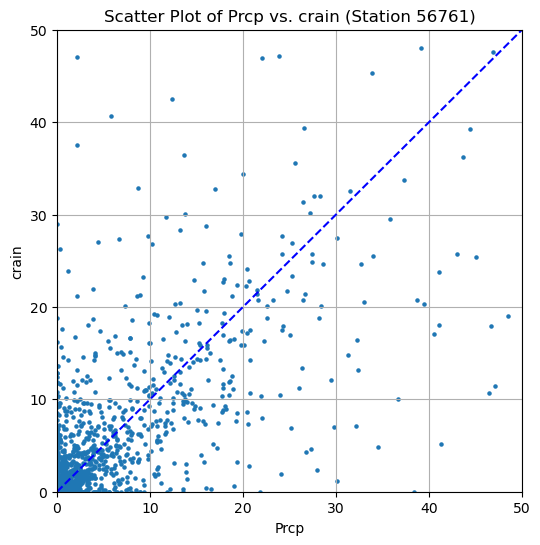

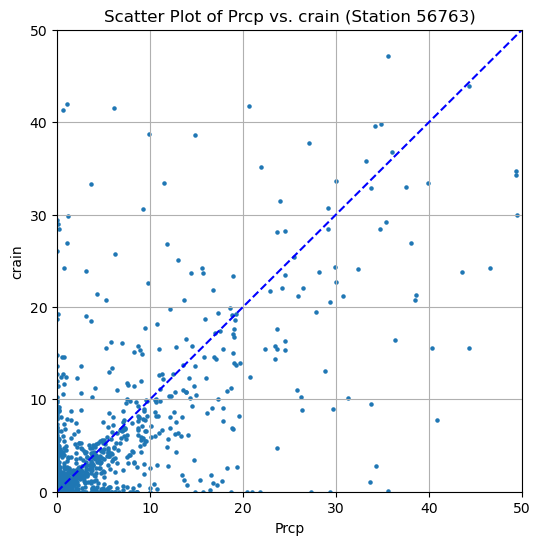

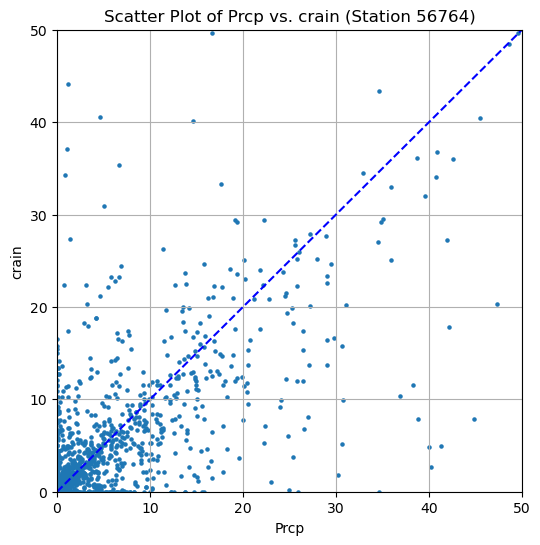

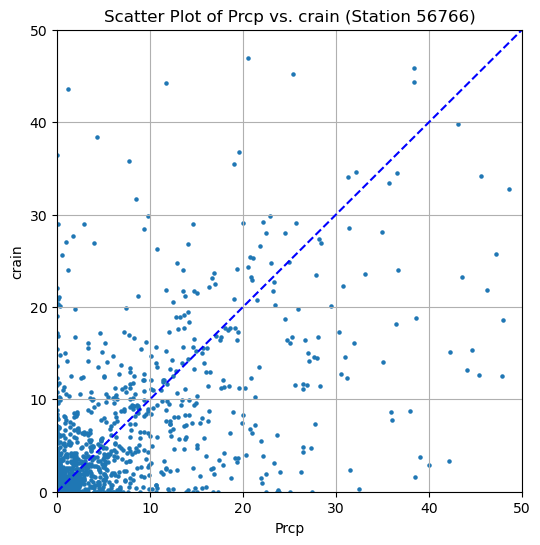

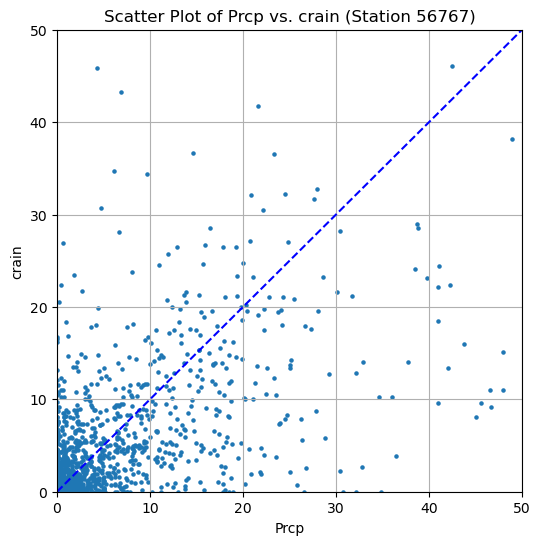

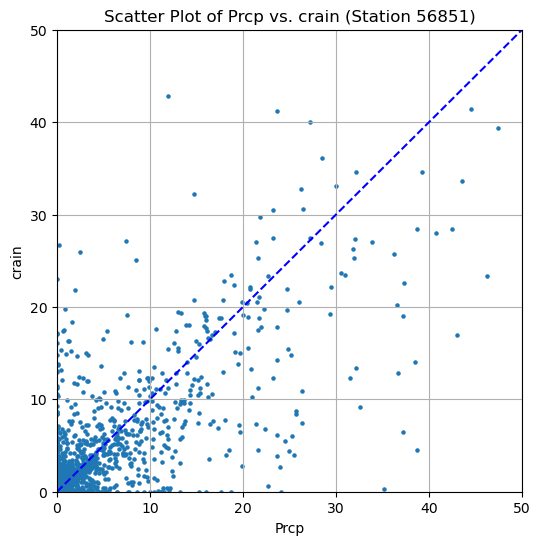

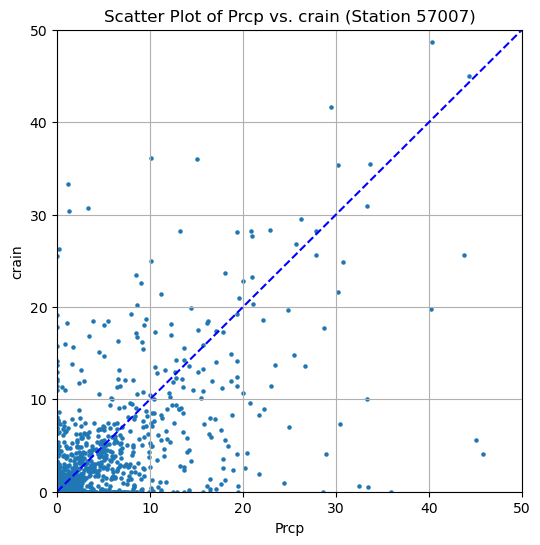

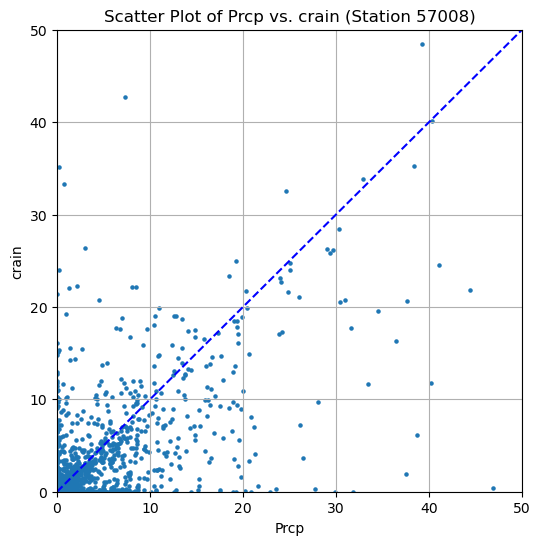

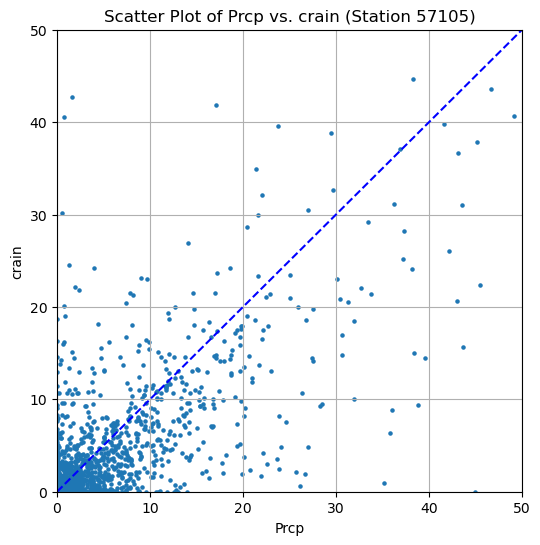

In [20]:
import matplotlib.pyplot as plt

# 按照station进行分组
grouped_data = merged_data.groupby('station')

# 遍历每个station，并绘制对应的散点图
for station, group in grouped_data:
    plt.figure(figsize=(6, 6))  # 调整图形大小
    plt.scatter(group['Prcp'], group['crain'], s = 5)  # 调整散点的透明度

    max_value = max(group[['Prcp', 'crain']].max())

    plt.plot([0, max_value], [0, max_value], 'b--')  # 添加对角线
    plt.title(f'Scatter Plot of Prcp vs. crain (Station {station})')
    plt.xlabel('Prcp')
    plt.ylabel('crain')

    plt.xlim(0, 50)  # 设置 x 轴范围
    plt.ylim(0, 50)  # 设置 y 轴范围
    plt.grid(True)
    plt.show()


In [21]:
# 导入必要的库
import pandas as pd

# 按照站点分组并计算相关系数
grouped_data = merged_data.groupby('station').apply(lambda x: x[['crain', 'Prcp']].corr().iloc[0, 1])

# 逐行打印每个站点的相关系数
for station, correlation in grouped_data.items():
    print(f"Station {station}: Correlation = {correlation}")


Station 55279: Correlation = 0.6706703673162614
Station 55294: Correlation = 0.5835261816431202
Station 55299: Correlation = 0.7345307026271509
Station 55493: Correlation = 0.67078233698342
Station 55593: Correlation = 0.6509711658339439
Station 55690: Correlation = 0.561164854424681
Station 55696: Correlation = 0.6613040699982442
Station 56004: Correlation = 0.48069139223560114
Station 56016: Correlation = 0.6126649300906429
Station 56018: Correlation = 0.6358123971517754
Station 56021: Correlation = 0.6446963025609851
Station 56029: Correlation = 0.5265595985276011
Station 56034: Correlation = 0.5740139261392031
Station 56038: Correlation = 0.5759281061839976
Station 56043: Correlation = 0.6600334676192713
Station 56045: Correlation = 0.5365800482081583
Station 56046: Correlation = 0.6596113103213208
Station 56067: Correlation = 0.6789080994730772
Station 56071: Correlation = 0.5367409823813114
Station 56074: Correlation = 0.5681666361249326
Station 56079: Correlation = 0.60004995757

/var/folders/qf/6td8xpjs0dx3h8n6_0_j266c0000gn/T/ipykernel_6801/1394083856.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_data = merged_data.groupby('station').apply(lambda x: x[['crain', 'Prcp']].corr().iloc[0, 1])


In [22]:
# 将 grouped_data 转换为 DataFrame
correlation_df = grouped_data.reset_index()

# 重命名列
correlation_df.columns = ['station', 'Correlation_0024']

# 打印 DataFrame
print(correlation_df)


    station  Correlation_0024
0     55279          0.670670
1     55294          0.583526
2     55299          0.734531
3     55493          0.670782
4     55593          0.650971
..      ...               ...
134   56767          0.700753
135   56851          0.814265
136   57007          0.667218
137   57008          0.719700
138   57105          0.793686

[139 rows x 2 columns]


In [23]:
mean_value = correlation_df['Correlation_0024'].mean()

mean_value

0.666621160896004

##### Grouped by years

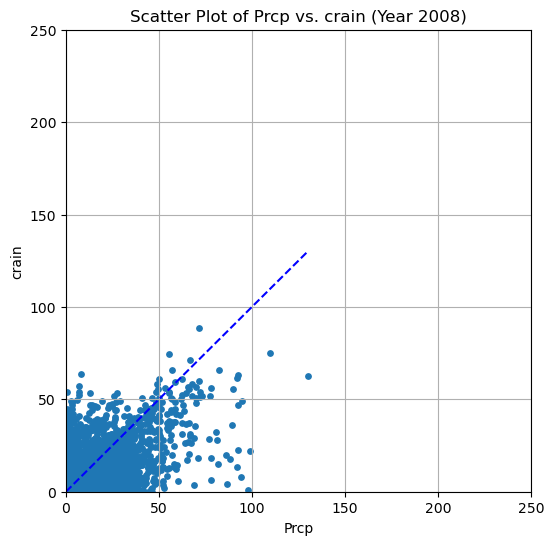

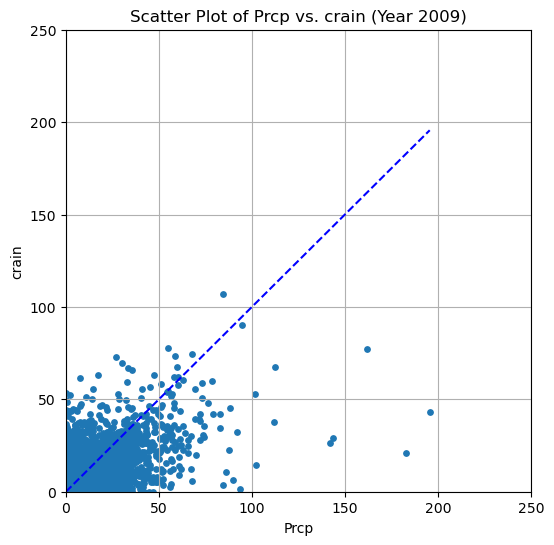

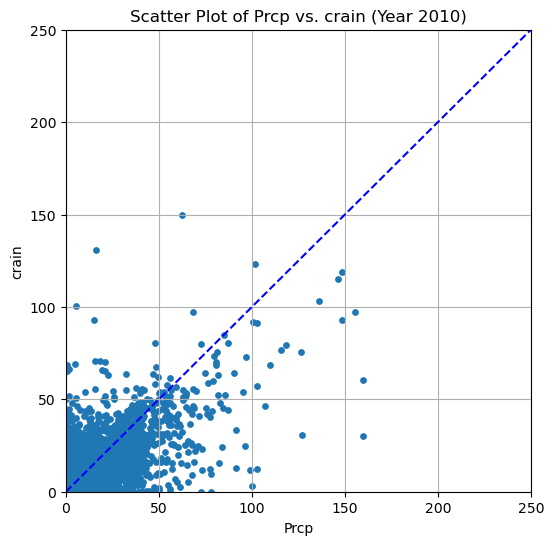

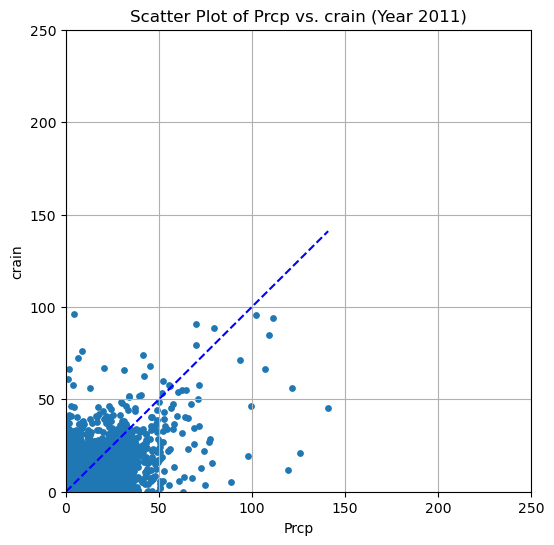

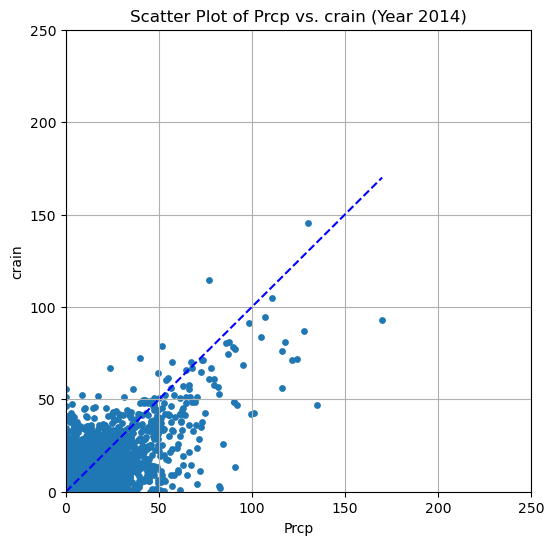

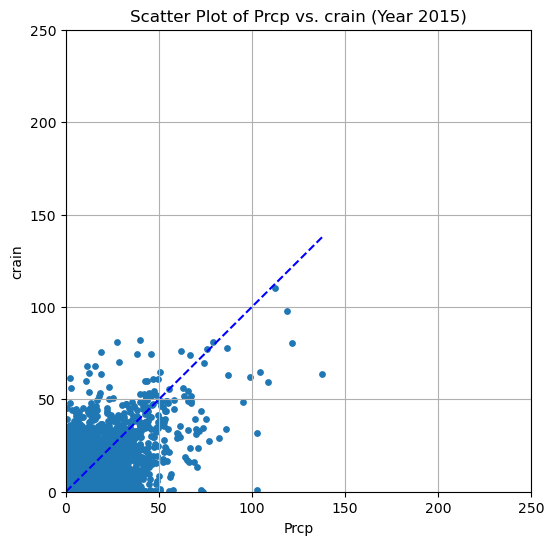

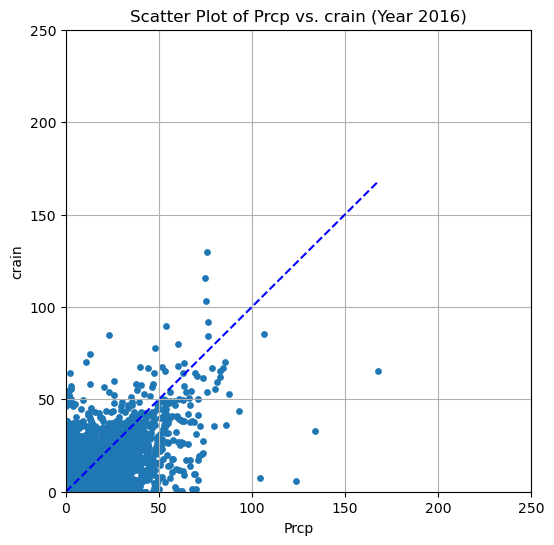

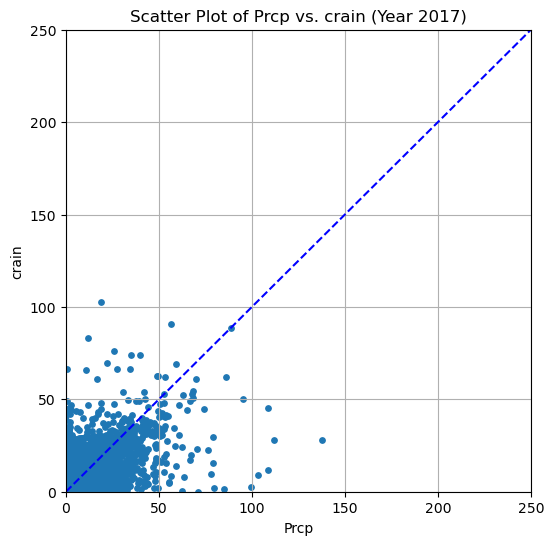

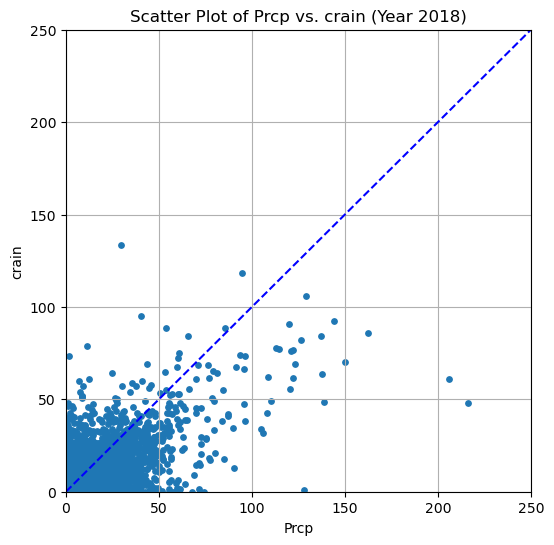

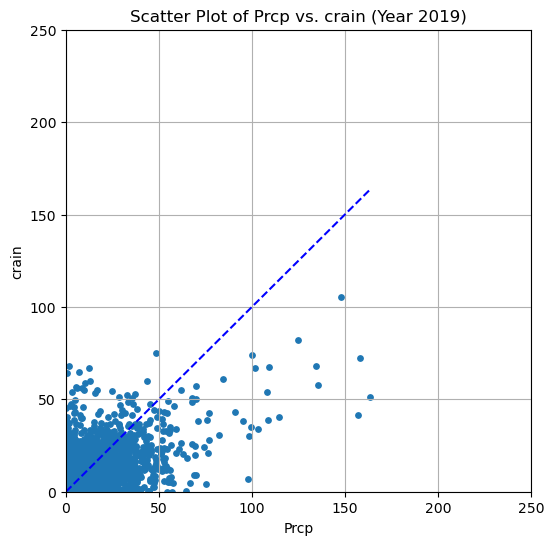

In [24]:
import matplotlib.pyplot as plt

# 按照 'year' 列进行分组
grouped_data = merged_data.groupby('year')

# 遍历每个年份，并绘制对应的散点图
for year, group in grouped_data:
    plt.figure(figsize=(6, 6))  # 调整图形大小
    plt.scatter(group['Prcp'], group['crain'], s = 15)  # 调整散点的透明度

    max_value = max(group[['Prcp', 'crain']].max())

    plt.plot([0, max_value], [0, max_value], 'b--')  # 添加对角线
    plt.title(f'Scatter Plot of Prcp vs. crain (Year {year})')
    plt.xlabel('Prcp')
    plt.ylabel('crain')

    plt.xlim(0, 250)  # 设置 x 轴范围
    plt.ylim(0, 250)  # 设置 y 轴范围
    plt.grid(True)
    plt.show()


In [25]:
# 导入必要的库
import pandas as pd

# 按照站点分组并计算相关系数
grouped_data = merged_data.groupby('year').apply(lambda x: x[['crain', 'Prcp']].corr().iloc[0, 1])

# 逐行打印每个站点的相关系数
for station, correlation in grouped_data.items():
    print(f"Station {station}: Correlation = {correlation}")

Station 2008: Correlation = 0.6673337701143688
Station 2009: Correlation = 0.6778335000346234
Station 2010: Correlation = 0.7211044233658181
Station 2011: Correlation = 0.6774146934201011
Station 2012: Correlation = 0.6908678218416741
Station 2013: Correlation = 0.7348772673879864
Station 2014: Correlation = 0.7385450224929795
Station 2015: Correlation = 0.7151079488311805
Station 2016: Correlation = 0.7221239735519226
Station 2017: Correlation = 0.570415127420204
Station 2018: Correlation = 0.6824030948141919
Station 2019: Correlation = 0.6653259075807346


/var/folders/qf/6td8xpjs0dx3h8n6_0_j266c0000gn/T/ipykernel_6801/3805172682.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_data = merged_data.groupby('year').apply(lambda x: x[['crain', 'Prcp']].corr().iloc[0, 1])


In [26]:
# 将 grouped_data 转换为 DataFrame
correlation_df = grouped_data.reset_index()

# 重命名列
correlation_df.columns = ['year', 'Correlation']

# 打印 DataFrame
print(correlation_df)

    year  Correlation
0   2008     0.667334
1   2009     0.677834
2   2010     0.721104
3   2011     0.677415
4   2012     0.690868
5   2013     0.734877
6   2014     0.738545
7   2015     0.715108
8   2016     0.722124
9   2017     0.570415
10  2018     0.682403
11  2019     0.665326


In [27]:
mean_value = correlation_df['Correlation'].mean()

mean_value

0.6886127125713154

#### 2.3.2 Relative_Error 0.1 日尺度

In [28]:
merged_data

date station     crain  Prcp  year  Relative_Error
0      2008-01-02   55279  0.000000   0.0  2008             NaN
1      2008-01-03   55279  0.000000   0.0  2008             NaN
2      2008-01-04   55279  0.000000   0.0  2008             NaN
3      2008-01-05   55279  0.000000   0.1  2008        1.000000
4      2008-01-06   55279  0.300000   0.0  2008             inf
...           ...     ...       ...   ...   ...             ...
567391 2019-12-27   57105  0.000000   0.0  2019             NaN
567392 2019-12-28   57105  0.000000   0.0  2019             NaN
567393 2019-12-29   57105  0.000000   0.0  2019             NaN
567394 2019-12-30   57105  0.000000   0.0  2019             NaN
567395 2019-12-31   57105  0.223281   0.3  2019        0.255732

[566217 rows x 6 columns]

In [29]:
# 将 error_2_list 中的 station 和 date 列作为条件，从 HoursP_fix 中提取符合条件的行

extracted_data = merged_data.merge(Relative_Error_010, on=['station', 'year'])

# 打印提取出的数据
extracted_data

date station   crain_x  Prcp_x  year  Relative_Error_x  \
0      2012-01-01   55279  0.000000     0.0  2012               NaN   
1      2012-01-02   55279  0.000000     0.1  2012          1.000000   
2      2012-01-03   55279  0.000000     0.0  2012               NaN   
3      2012-01-04   55279  0.000000     0.0  2012               NaN   
4      2012-01-05   55279  0.000000     0.0  2012               NaN   
...           ...     ...       ...     ...   ...               ...   
210890 2013-12-25   57008  0.196239     0.2  2013          0.018804   
210891 2013-12-28   57008  0.000000     0.0  2013               NaN   
210892 2013-12-29   57008  0.000000     0.0  2013               NaN   
210893 2013-12-30   57008  0.000000     0.0  2013               NaN   
210894 2013-12-31   57008  0.000000     0.0  2013               NaN   

           crain_y  Prcp_y  Relative_Error_y  
0       326.943803   325.9          0.003203  
1       326.943803   325.9          0.003203  
2       326.943803   325.9          0.003203  
3       326.943803   325.9          0.003203  
4       326.943803   325.9          0.003203  
...            ...     ...               ...  
210890  554.491445   554.7          0.000376  
210891  554.491445   554.7          0.000376  
210892  554.491445   554.7          0.000376  
210893  554.491445   554.7          0.000376  
210894  554.491445   554.7          0.000376  

[210895 rows x 9 columns]

In [30]:
# 删除重复的列
extracted_data.drop(['crain_y', 'Prcp_y'], axis=1, inplace=True)
extracted_data.rename(columns={'crain_x': 'crain', 'Prcp_x': 'Prcp'}, inplace=True)

Relative_Error_010_daily = extracted_data

print(Relative_Error_010_daily)


             date station     crain  Prcp  year  Relative_Error_x  \
0      2012-01-01   55279  0.000000   0.0  2012               NaN   
1      2012-01-02   55279  0.000000   0.1  2012          1.000000   
2      2012-01-03   55279  0.000000   0.0  2012               NaN   
3      2012-01-04   55279  0.000000   0.0  2012               NaN   
4      2012-01-05   55279  0.000000   0.0  2012               NaN   
...           ...     ...       ...   ...   ...               ...   
210890 2013-12-25   57008  0.196239   0.2  2013          0.018804   
210891 2013-12-28   57008  0.000000   0.0  2013               NaN   
210892 2013-12-29   57008  0.000000   0.0  2013               NaN   
210893 2013-12-30   57008  0.000000   0.0  2013               NaN   
210894 2013-12-31   57008  0.000000   0.0  2013               NaN   

        Relative_Error_y  
0               0.003203  
1               0.003203  
2               0.003203  
3               0.003203  
4               0.003203  
...      

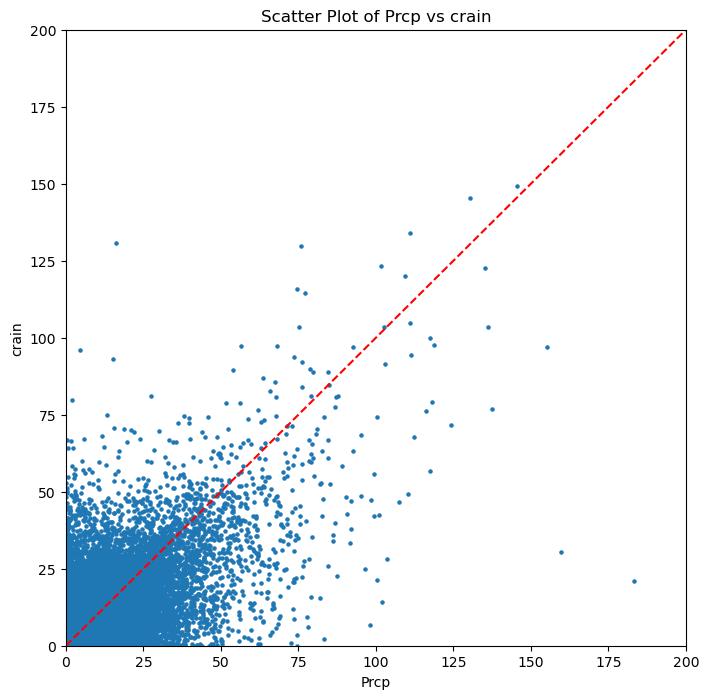

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 Relative_Error_010_daily 是您的 DataFrame 对象

# 提取 Prcp 和 crain 列的数据
prcp_data = Relative_Error_010_daily['Prcp']
crain_data = Relative_Error_010_daily['crain']

# 创建散点图
plt.figure(figsize=(8, 8))
plt.scatter(prcp_data, crain_data, s = 5)

# 设置 x 轴和 y 轴的范围
plt.xlim(0, 200)
plt.ylim(0, 200)

plt.plot([0, 450], [0, 450], color='red', linestyle='--', label='x = y')  # 添加 x=y 的线


# 添加标题和标签
plt.title('Scatter Plot of Prcp vs crain')
plt.xlabel('Prcp')
plt.ylabel('crain')

# 显示图形
plt.show()


In [32]:
from scipy.stats import pearsonr

# 清洗数据，删除包含 NaN 值的行
cleaned_data = Relative_Error_010_daily.dropna()

# 将无穷大值替换为 0
# cleaned_data.replace([np.inf, -np.inf], 0, inplace=True)

# 计算相关系数和 p 值
correlation, p_value = pearsonr(cleaned_data['crain'], cleaned_data['Prcp'])

# 格式化 p 值，保留四位小数
formatted_p_value = "{:.4f}".format(p_value)

print("相关系数为:", correlation)
print("显著性 p 值为:", formatted_p_value)

相关系数为: 0.6643170313029766
显著性 p 值为: 0.0000


In [33]:
# Relative_Error_010_daily.to_csv( path / 'Relative_Error_010_daily.csv')